In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import zipfile
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
os.mkdir('/tmp/360')
os.mkdir('/tmp/120')

In [4]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/MLAssignment/360 Rocks.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/360') #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/MLAssignment/120 Rocks.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/120') #Extracts the files into the /tmp folder
zip_ref.close()

In [6]:
os.listdir()

['.config', 'drive', 'sample_data']

In [7]:
os.chdir('..')

In [8]:
def getImage(path):
  folder_path = path
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
  image_files=sorted(image_files)
  #storing Labels
  labels=[i[0] for i in image_files]

  resized_images = []

  for image_file in image_files:
      image_path = os.path.join(folder_path, image_file)
      original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      target_size = (256, 256)
      resized_image = cv2.resize(original_image, target_size)
      resized_images.append(resized_image)
  flattened_image = [img.flatten() for img in resized_images]
  return resized_images,flattened_image,labels


In [9]:
resized_images_360,flattened_image_360,labels_360=getImage('/tmp/360')

In [10]:
resized_images_120,flattened_image_120,labels_120=getImage('/tmp/120')

In [11]:
X_train = np.array(resized_images_360)
X_train.shape
X_val = np.array(resized_images_120)

In [12]:
def standardize(image_data):
  means = np.mean(image_data, axis=0)
  std_devs = np.std(image_data, axis=0)
  # std_devs = np.where(std_devs == 0, 1, std_devs)
  standardized_data = (image_data - means) / (std_devs+1e-3)
  return standardized_data

In [13]:
standardized_data_360 = standardize(flattened_image_360)

In [14]:
is_null = np.isnan(flattened_image_360)
is_null.sum()

0

## 1. Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 95% of the variance?

**217**

In [16]:
pca = PCA()
pca.fit(standardized_data_360)
# Calculate the explained variance ratio for each PC
variance_ratio = pca.explained_variance_ratio_

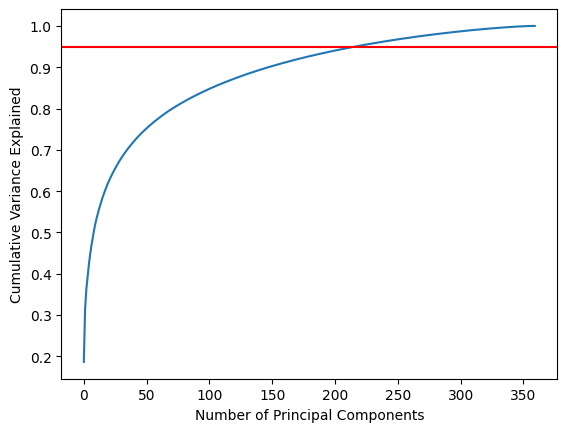

In [17]:
plt.plot(np.cumsum(variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
# Add a line at 97%
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [18]:
cumulative_variance_ratio = np.cumsum(variance_ratio)
components = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
components


217

## 2. Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 95% of variance using PCA

In [20]:
pca = PCA(n_components=components)
# Fit the PCA model to the data
pca.fit(standardized_data_360)
data_pca = pca.transform(standardized_data_360)

In [21]:
image_files = [f for f in os.listdir('/tmp/360') if f.endswith('.jpg')]
image_files=sorted(image_files)

In [22]:
import random
random.seed(42)
random_numbers = np.random.randint(0, 360, 10)
print(random_numbers)

[119 265 113  91  13 271  30 240  54 306]


In [23]:
random_numbers=list(random_numbers)
images=[image_files[i] for i in random_numbers]
images

['I_Rhyolite_12.jpg',
 'S_Chert_02.jpg',
 'I_Rhyolite_06.jpg',
 'I_Peridotite_08.jpg',
 'I_Basalt_02.jpg',
 'S_Chert_08.jpg',
 'I_Diorite_07.jpg',
 'S_Bituminous Coal_01.jpg',
 'I_Granite_07.jpg',
 'S_Micrite_07.jpg']

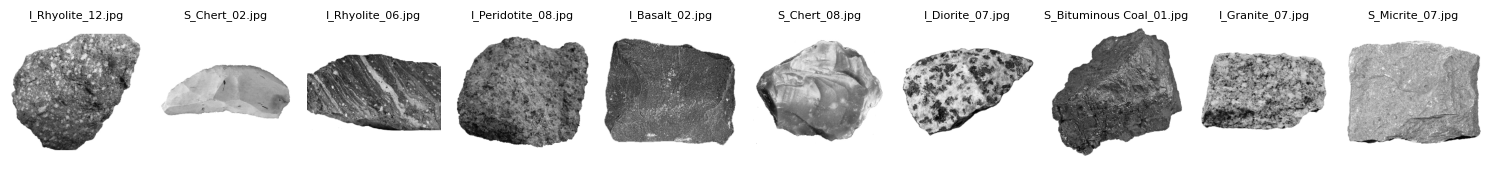

In [24]:
num_images_to_plot = 10  # Adjust as needed
plt.figure(figsize=(15, 6))

for ind,i in enumerate(random_numbers):

  plt.subplot(2, 10, ind + 1)
  plt.imshow(resized_images_360[i], cmap='gray')
  plt.title(f'{image_files[i]}', fontsize=8)
  plt.axis('off')


plt.tight_layout()
plt.show()

In [25]:
target_size = (256, 256)
approximated_data = pca.inverse_transform(data_pca)
approximated_images = [data.reshape(target_size) for data in approximated_data]

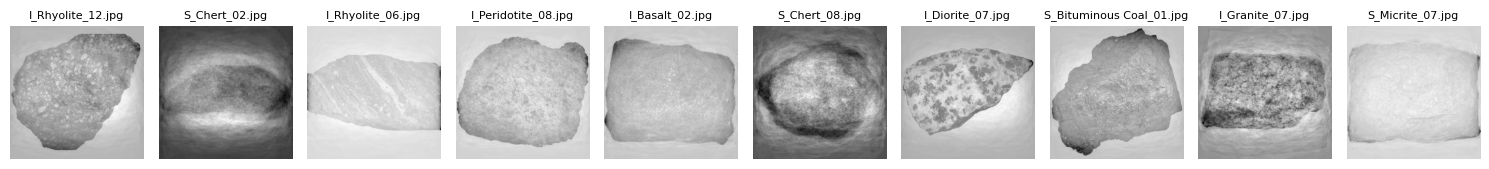

In [26]:
plt.figure(figsize=(15, 6))
num_images_to_plot = 10


for ind,i in enumerate(random_numbers):

  plt.subplot(2, 10, ind + 1)
  plt.imshow(approximated_images[i], cmap='gray')
  plt.title(f'{image_files[i]}', fontsize=8)
  plt.axis('off')


plt.tight_layout()
plt.show()





## 3. A. PCA with 2 dimensions

In [27]:
pca = PCA(n_components=2)
pca.fit(standardized_data_360)
data_pca = pca.transform(standardized_data_360)
variance_ratio = pca.explained_variance_ratio_

In [28]:
variance_ratio[0]

0.186557754785512

##3. A. Amount of Variance preserved with these 2 components

In [29]:
print(f"Explained Variance for the First Component: {variance_ratio[0]}")
print(f"Explained Variance for the Second Component: {variance_ratio[1]}")

Explained Variance for the First Component: 0.186557754785512
Explained Variance for the Second Component: 0.1269716657296337


In [30]:
label_mapping = {"S": 1, "M": 2, "I": 3}
new_labels = np.array([label_mapping[label] for label in labels_360])
len(new_labels)

360

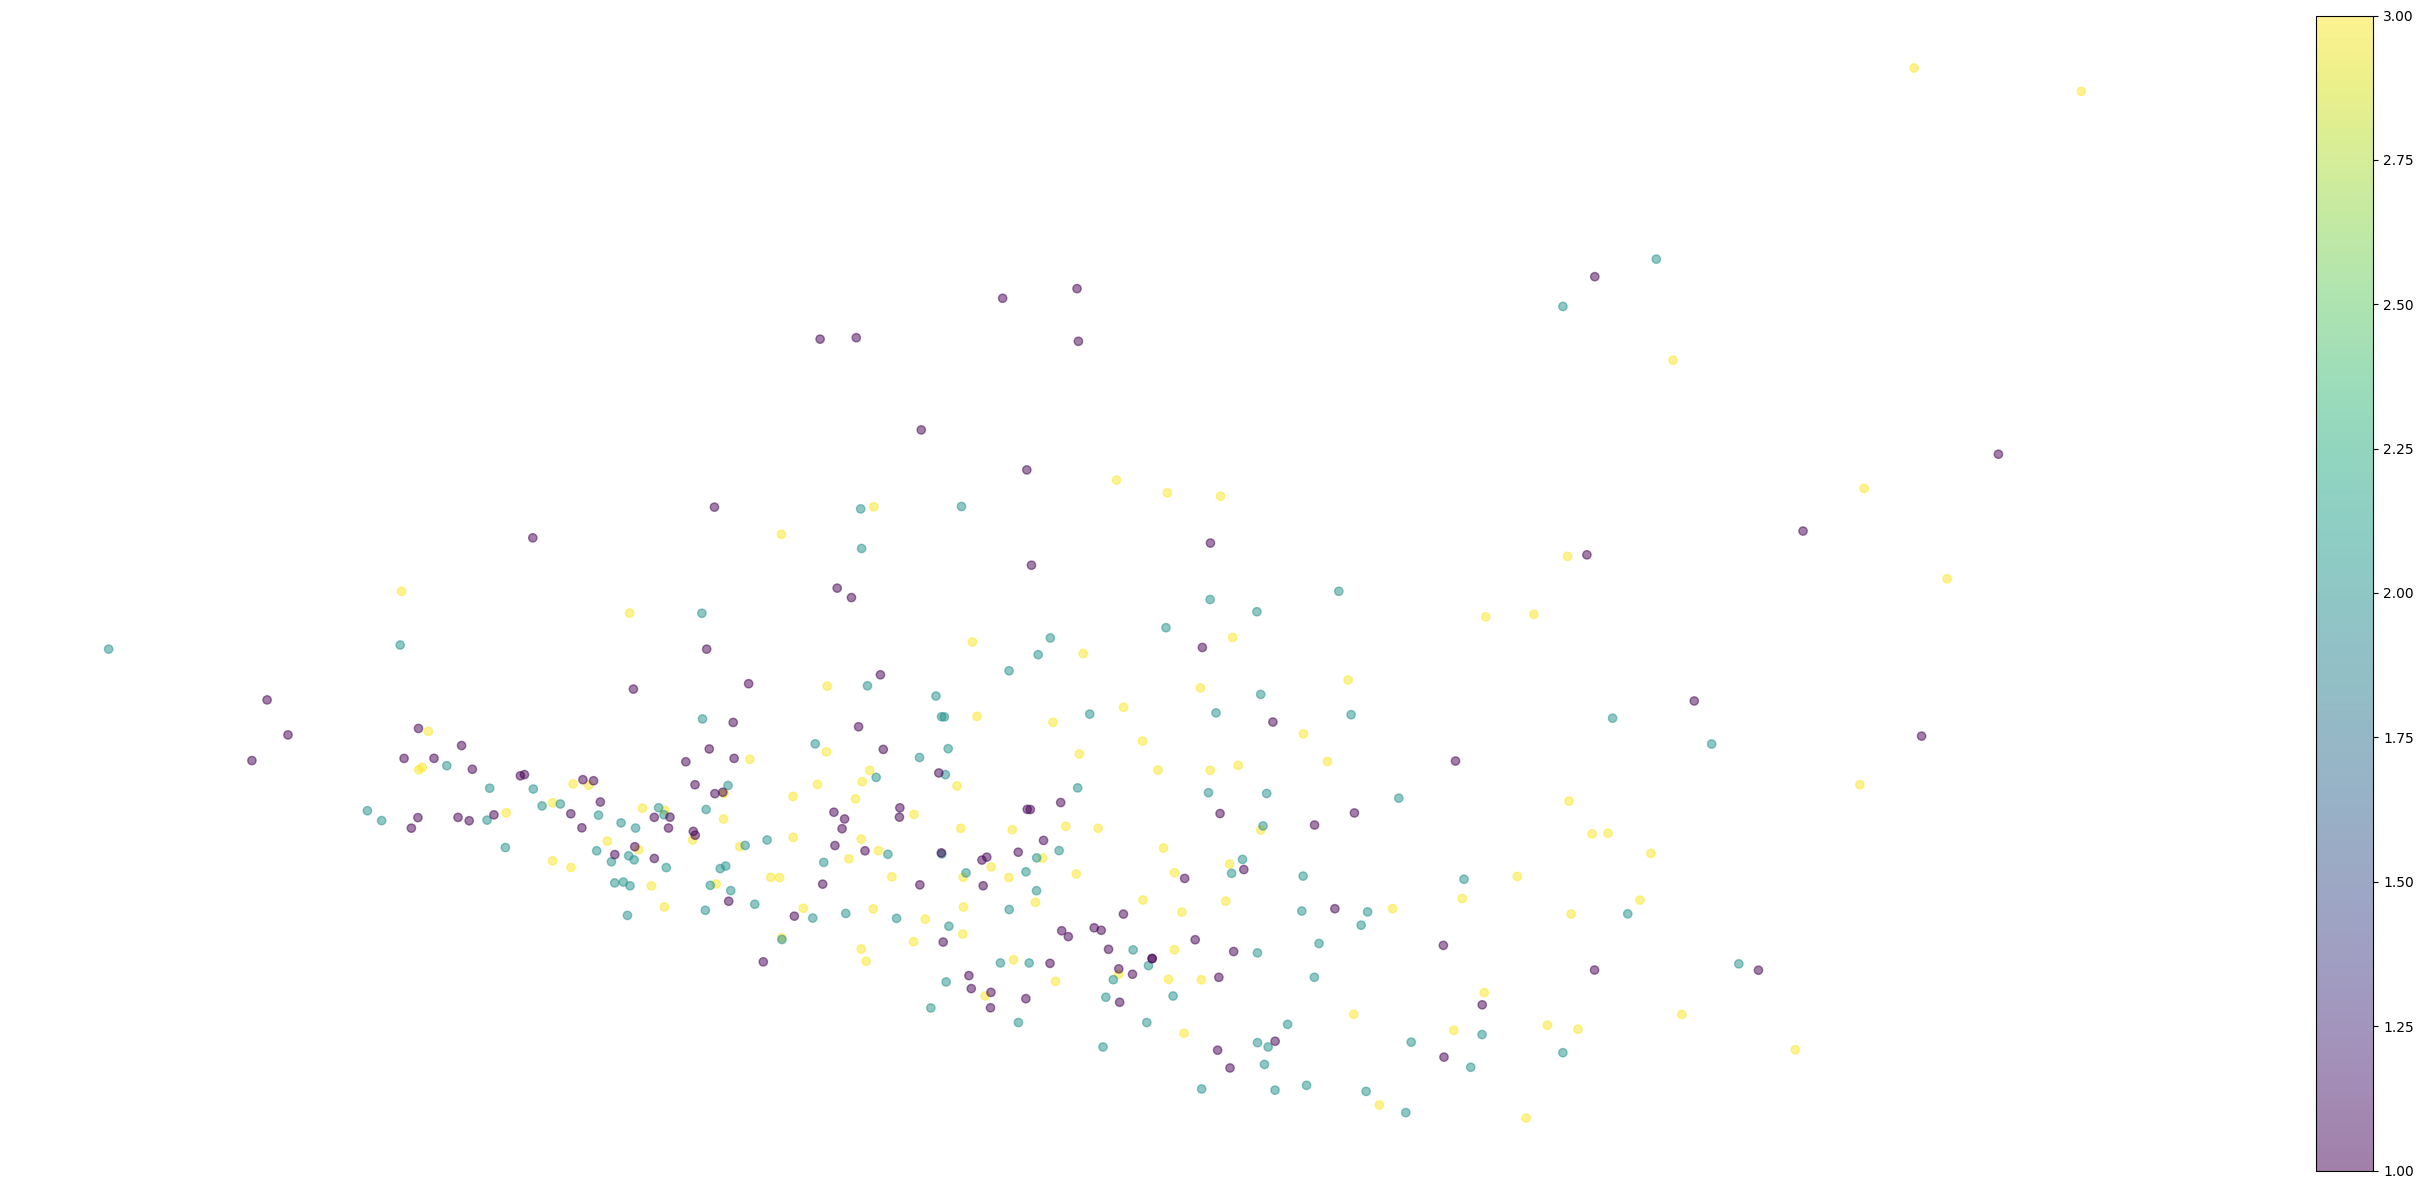

In [31]:
plt.figure(figsize=(35, 15))
plt.scatter(data_pca[:, 0], data_pca[:, 1],c=new_labels.astype(np.int8),  cmap="viridis", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

In [69]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[3., 3.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    print(digits)
    for digit in digits:
      # print(X_normalized[y == digit, 0])
      plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                c=[cmap(float(digit) / 3)], alpha=0.5)
    # labels.append(f"{digit}: {['I', 'M', 'S'][digit]}")
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 3),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(32, 32)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)
    plt.legend({'I', 'M', 'S'}, title='Legend', loc='upper left',fontsize="20")

In [70]:
resized_images_2 = []

for image_file in image_files:
    image_path = os.path.join('/tmp/360', image_file)
    # Load the original image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    target_size = (32, 32)  # Set the desired size (width, height)
    resized_image = cv2.resize(original_image, target_size)
    resized_images_2.append(resized_image)

## 3 B. Scatter Plots of Components with some  Images a) PCA

[1 2 3]


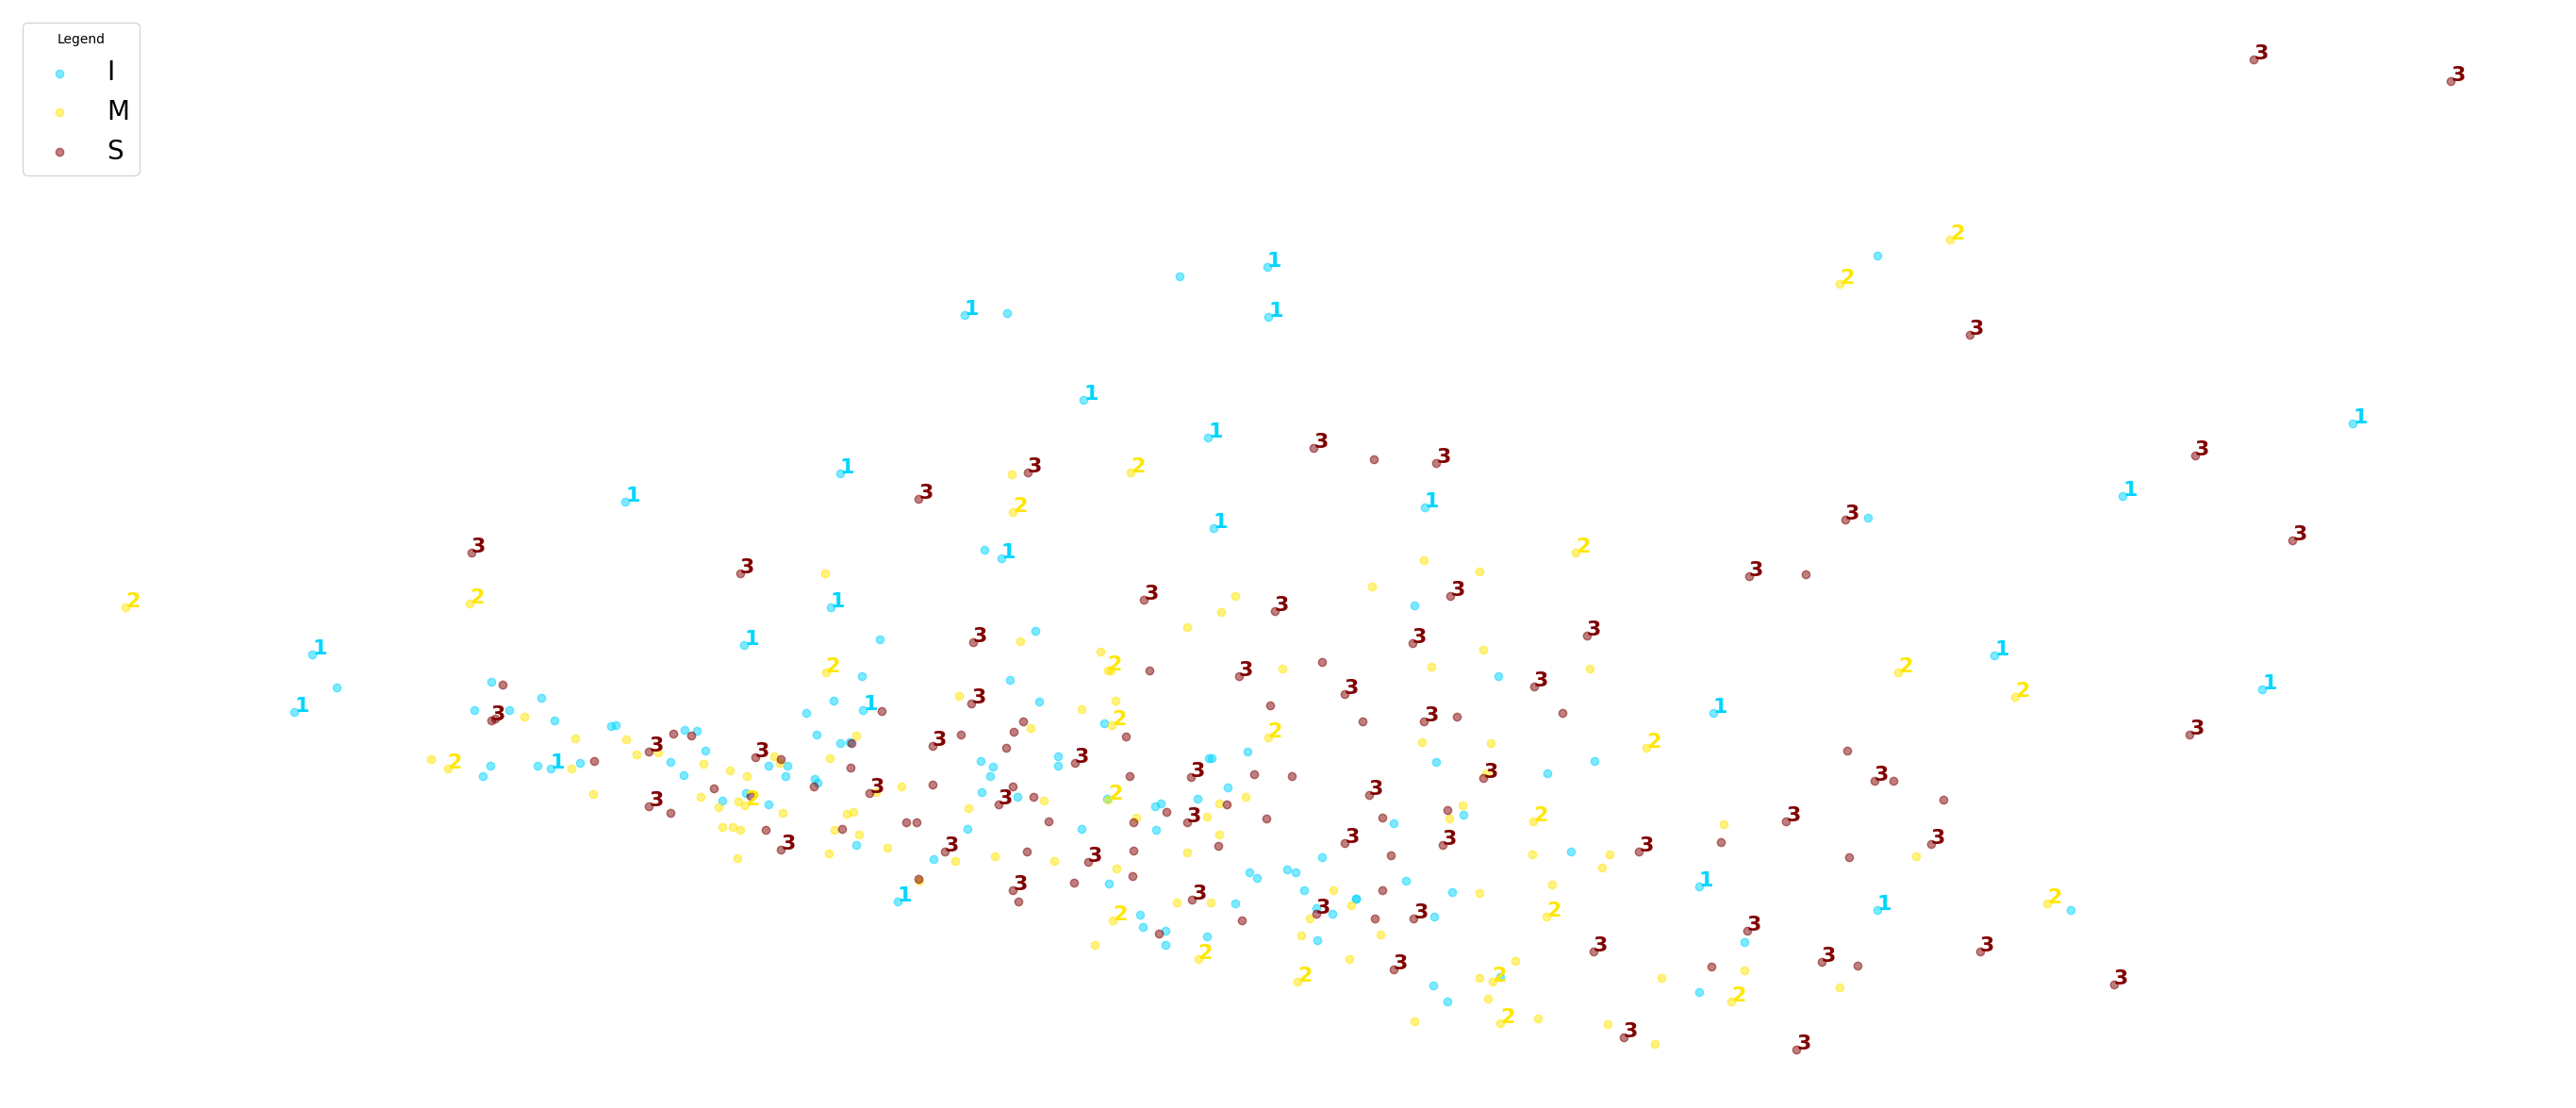

In [71]:
plot_digits(data_pca,new_labels,figsize=(35, 15))

[1 2 3]


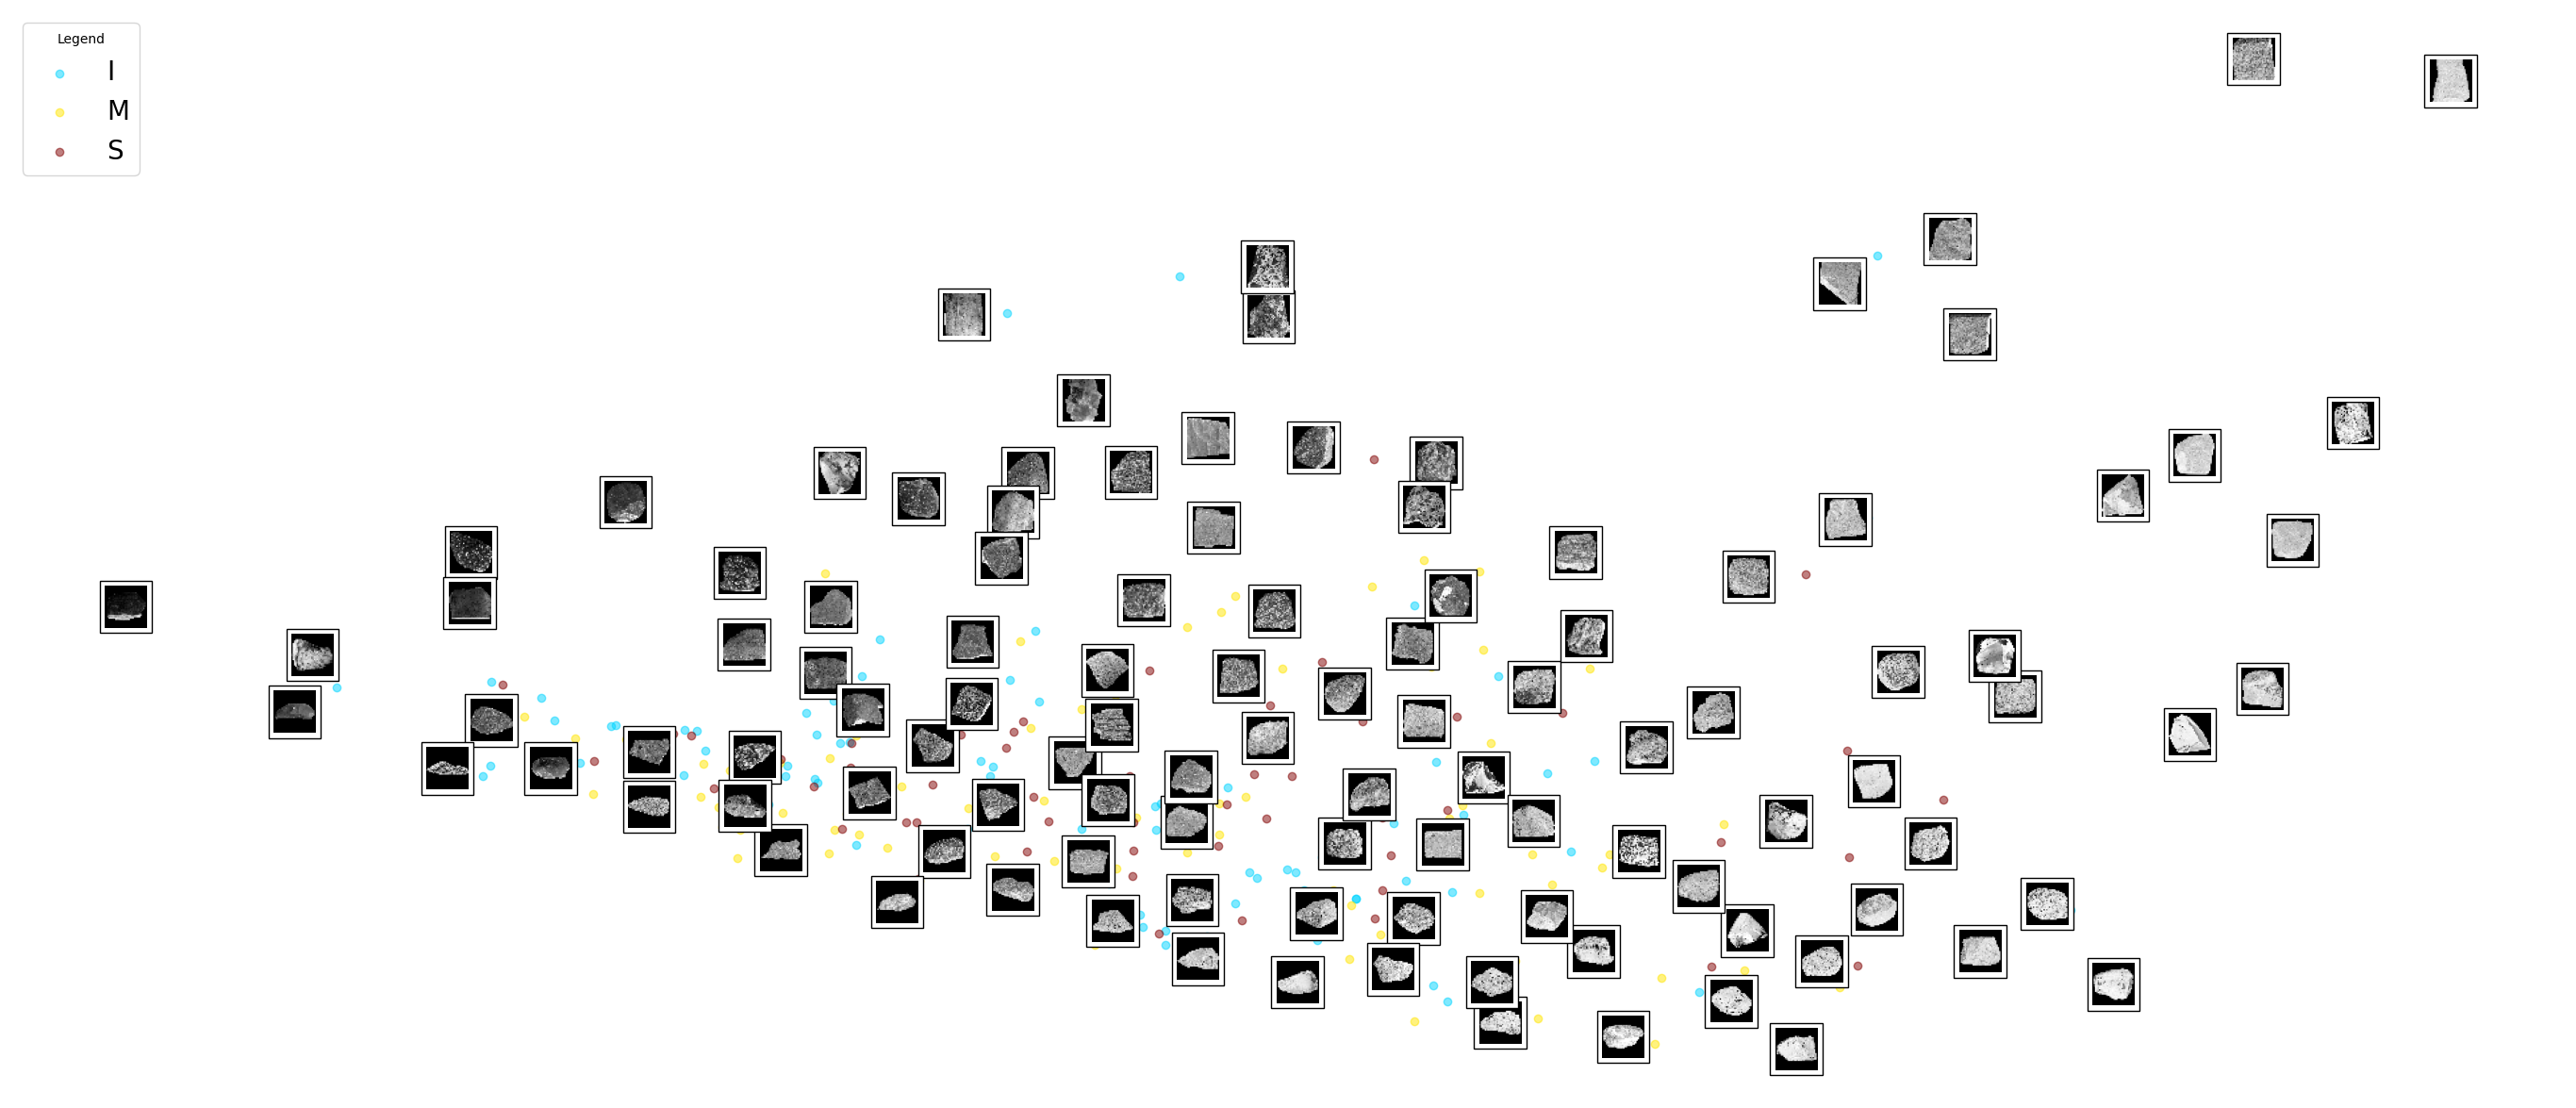

In [72]:
plot_digits(data_pca,new_labels,images=resized_images_2, figsize=(35, 15))

## 3 B. Scatter Plots of Components with some  Images b) TSNE

In [73]:
from sklearn.manifold import TSNE

[1 2 3]


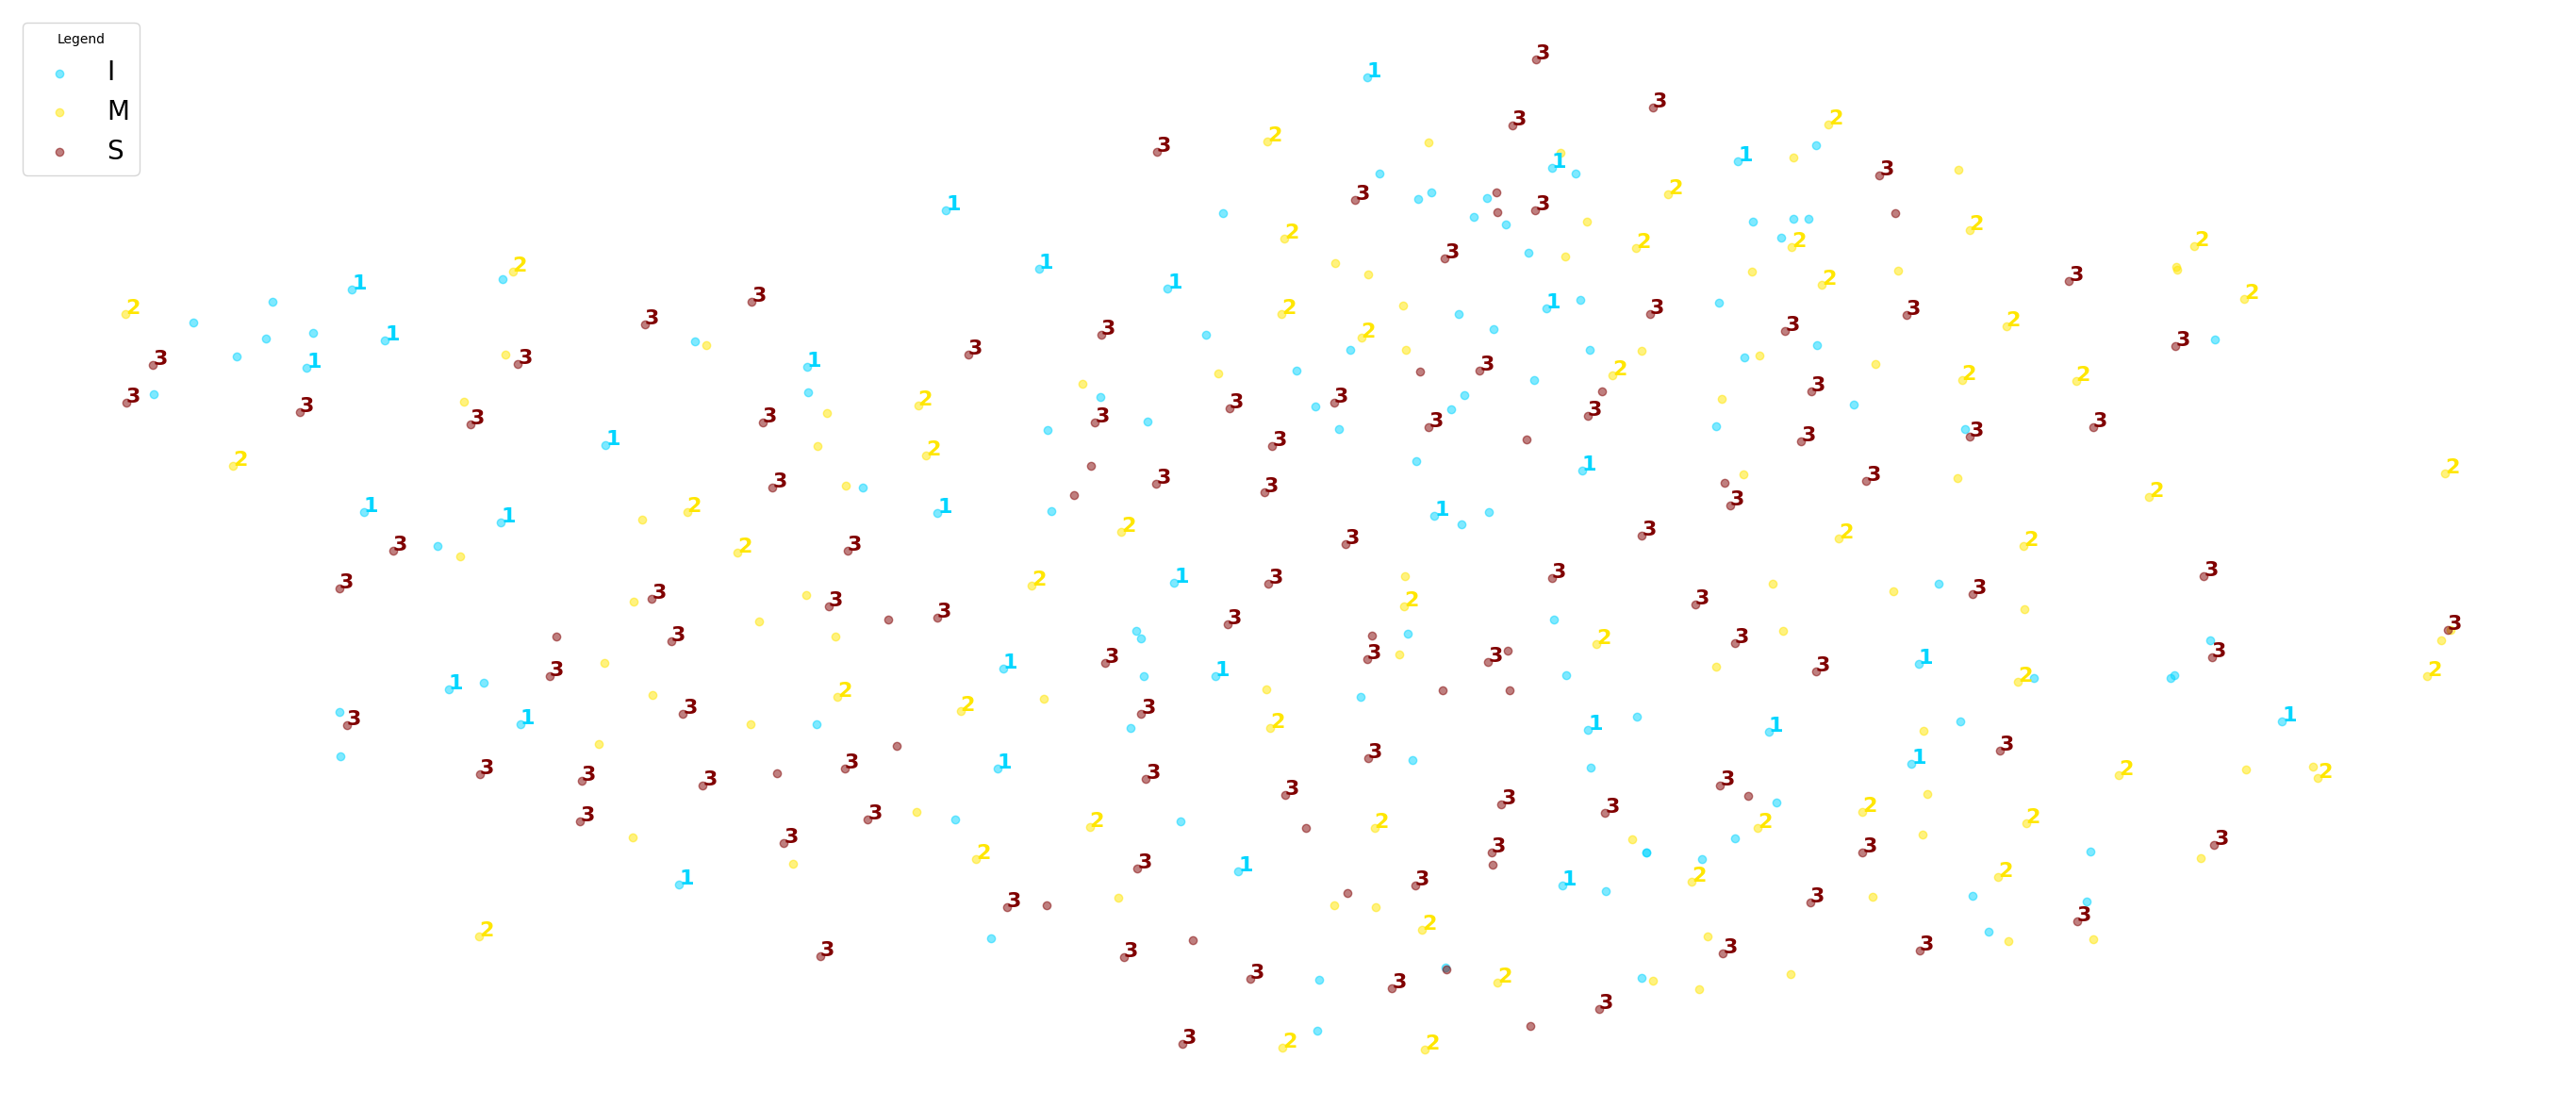

In [74]:
tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
data_tnse = tsne_subset.fit_transform(standardized_data_360)

plot_digits(data_tnse,new_labels,figsize=(35, 15))

[1 2 3]


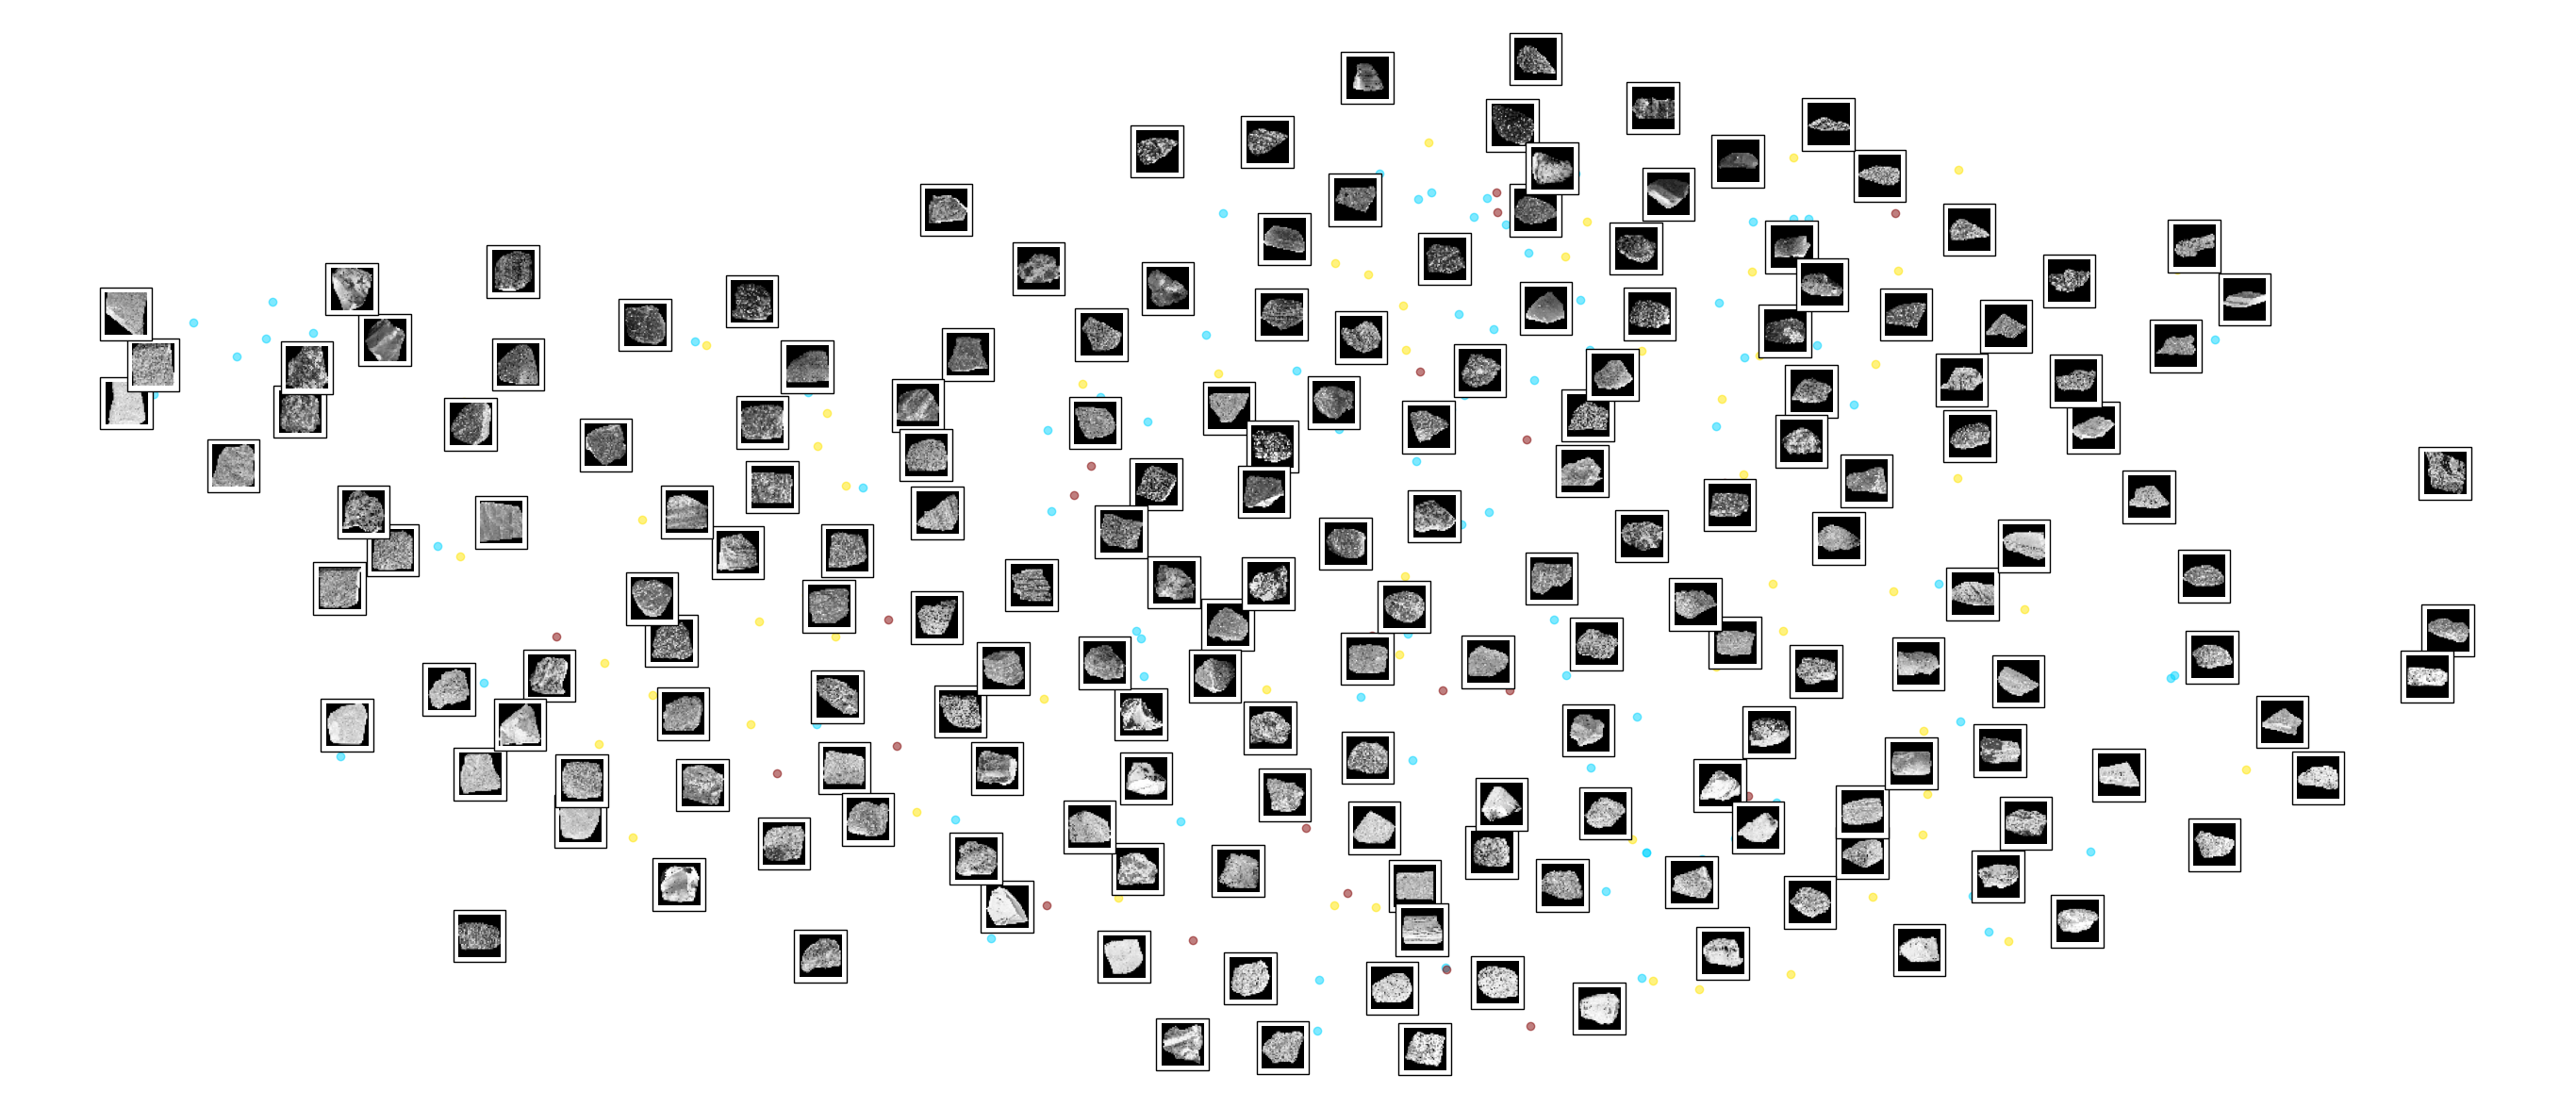

In [78]:
plot_digits(data_tnse,new_labels,images=resized_images_2, figsize=(35, 15))

## 3 B. Scatter Plots of Components with some  Images c) LLE

In [75]:
from sklearn.manifold import LocallyLinearEmbedding

[1 2 3]


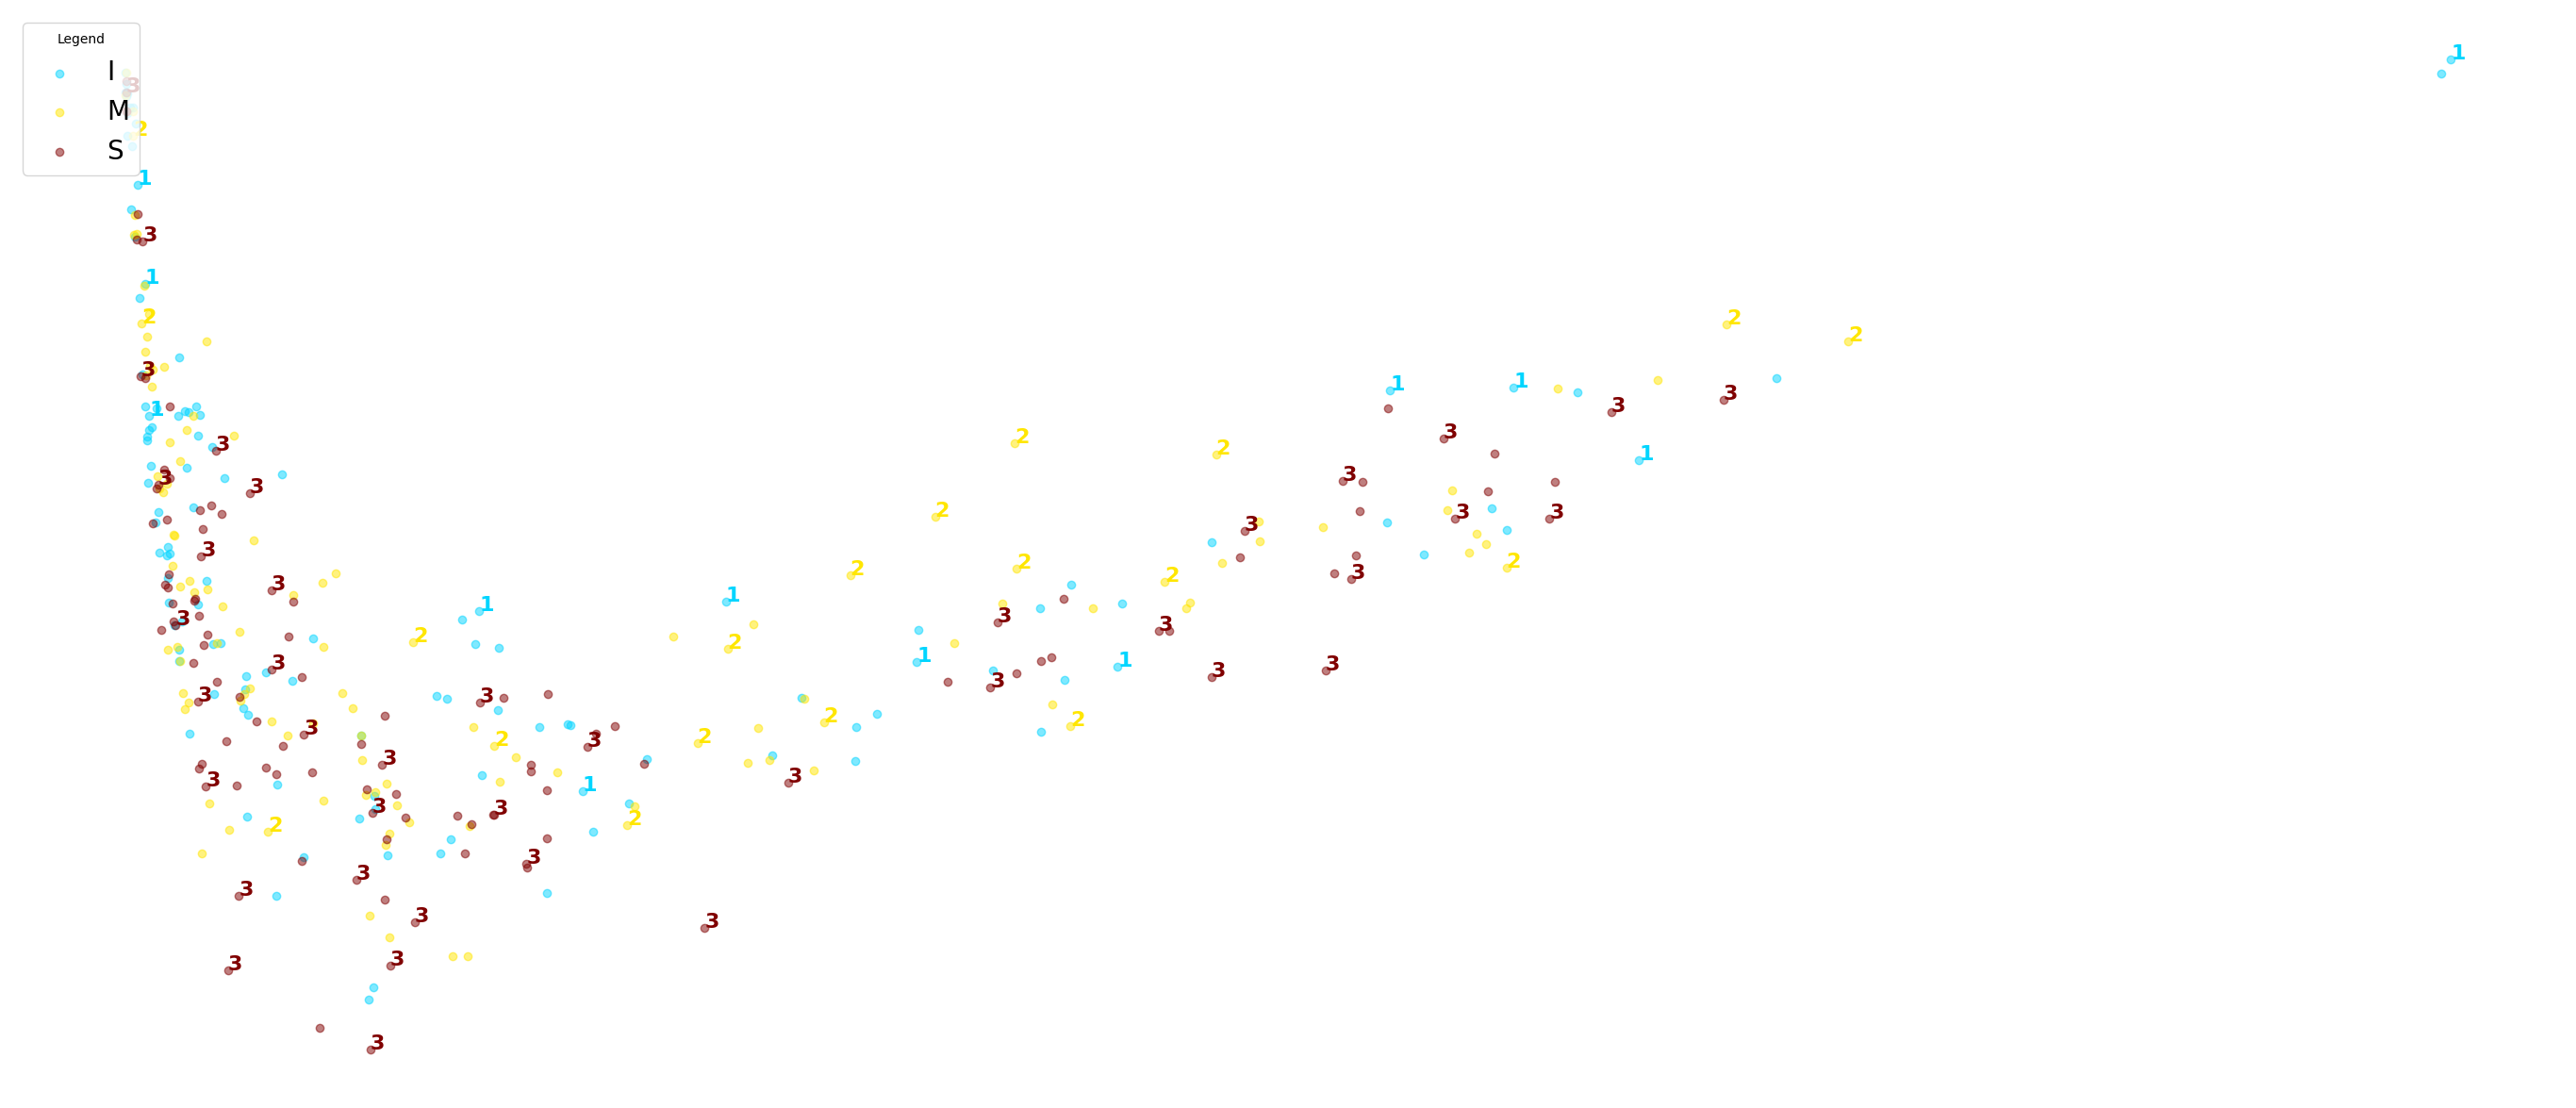

In [76]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_lle_reduced = lle.fit_transform(standardized_data_360)
plot_digits(X_lle_reduced, new_labels,figsize=(35, 15))

[1 2 3]


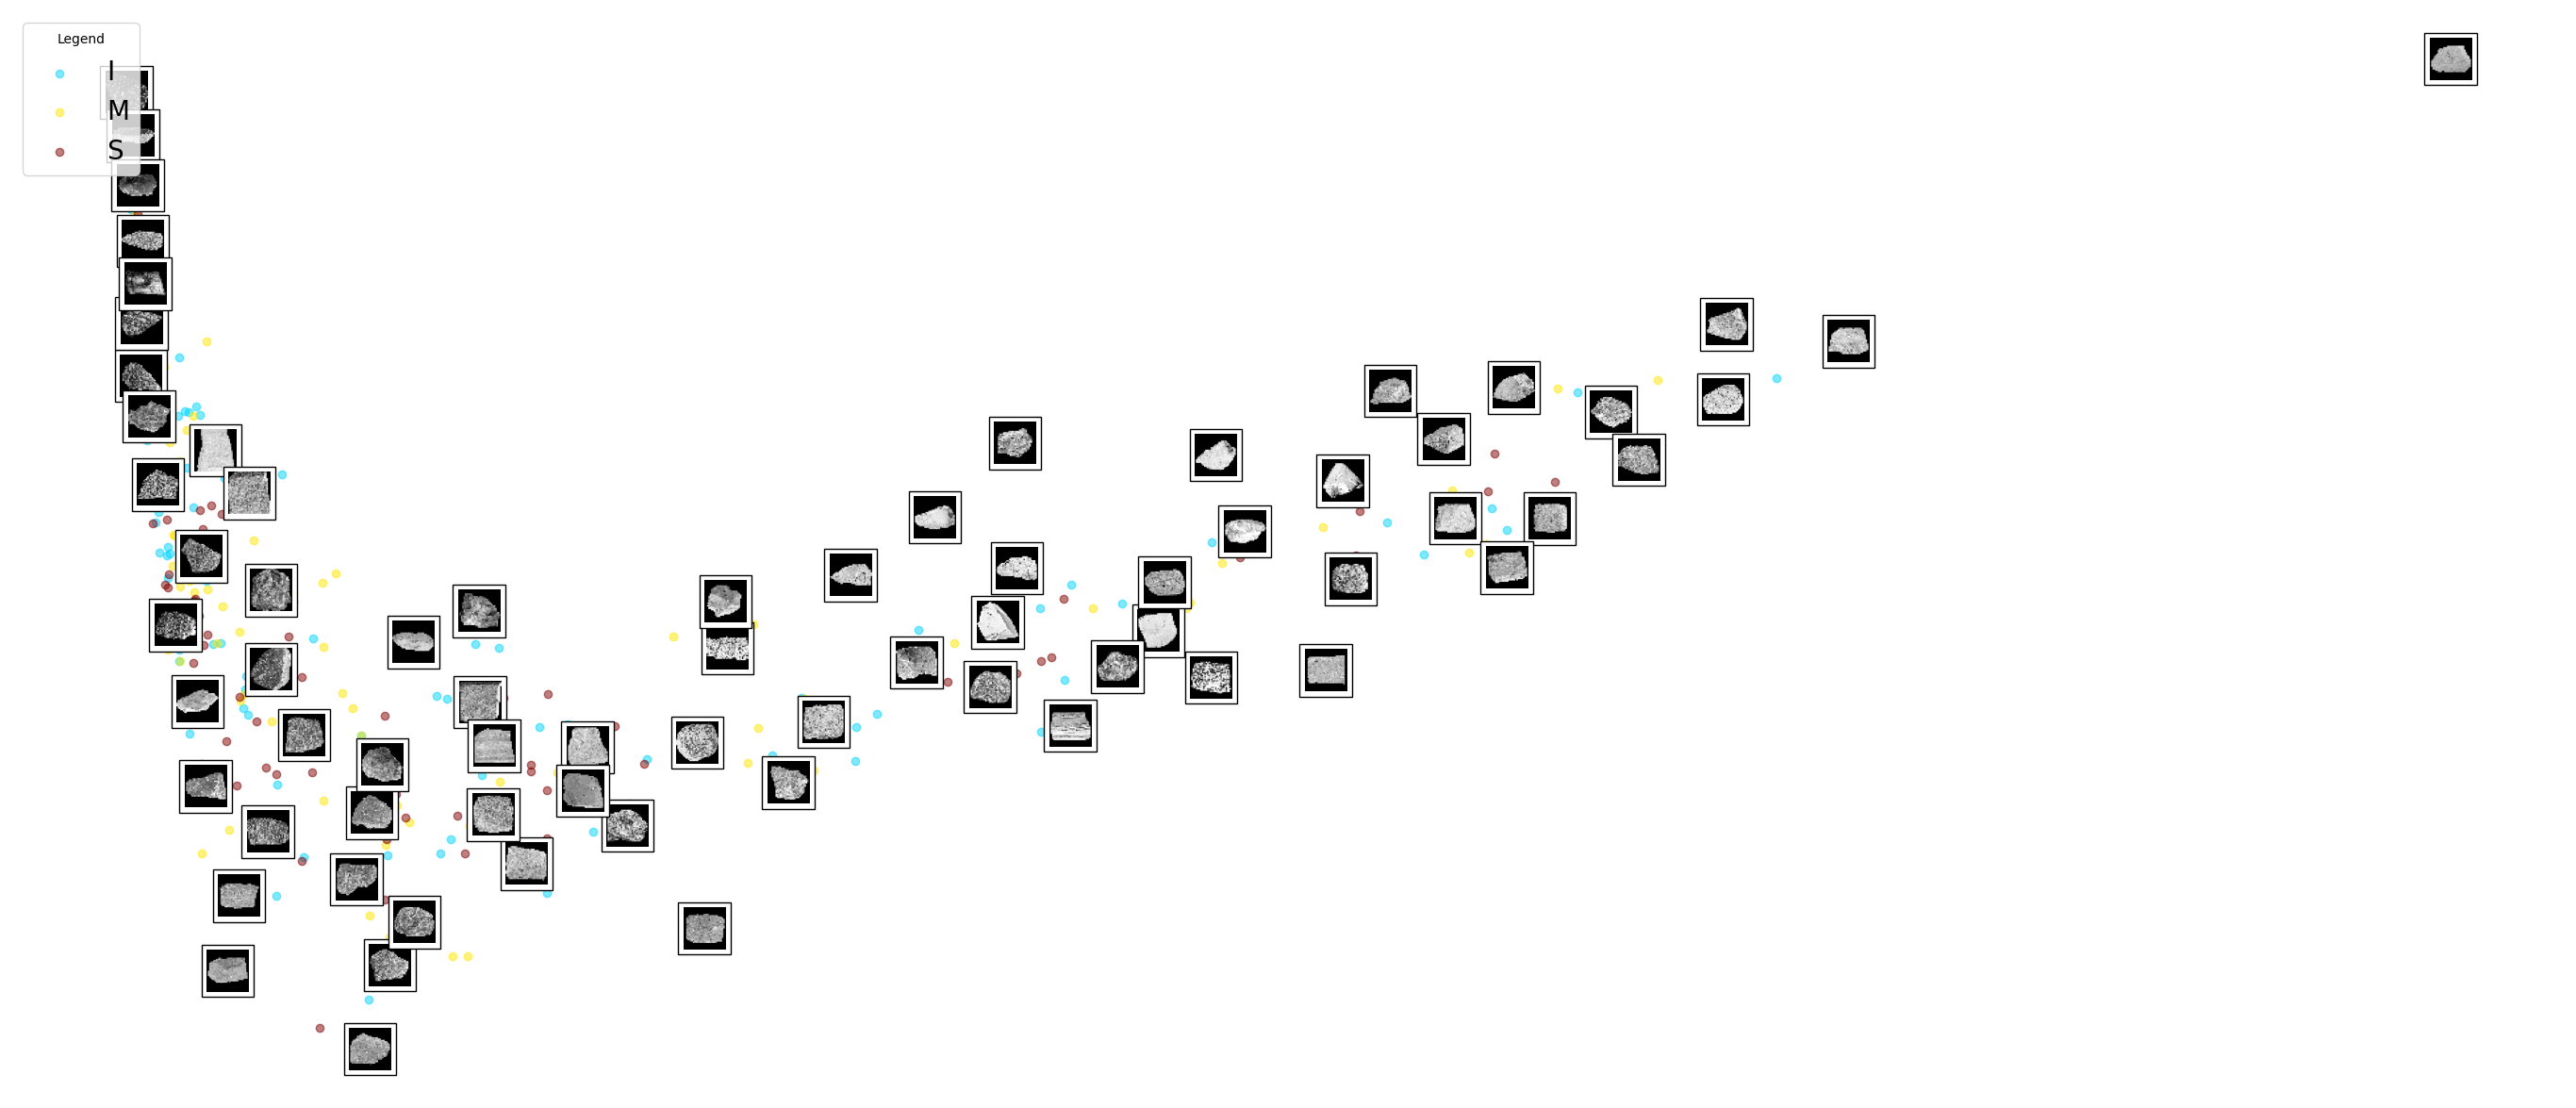

In [77]:
plot_digits(X_lle_reduced,new_labels,images=resized_images_2, figsize=(35, 15))

## 3 B. Scatter Plots of Components with some  Images d) MDS

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


[1 2 3]


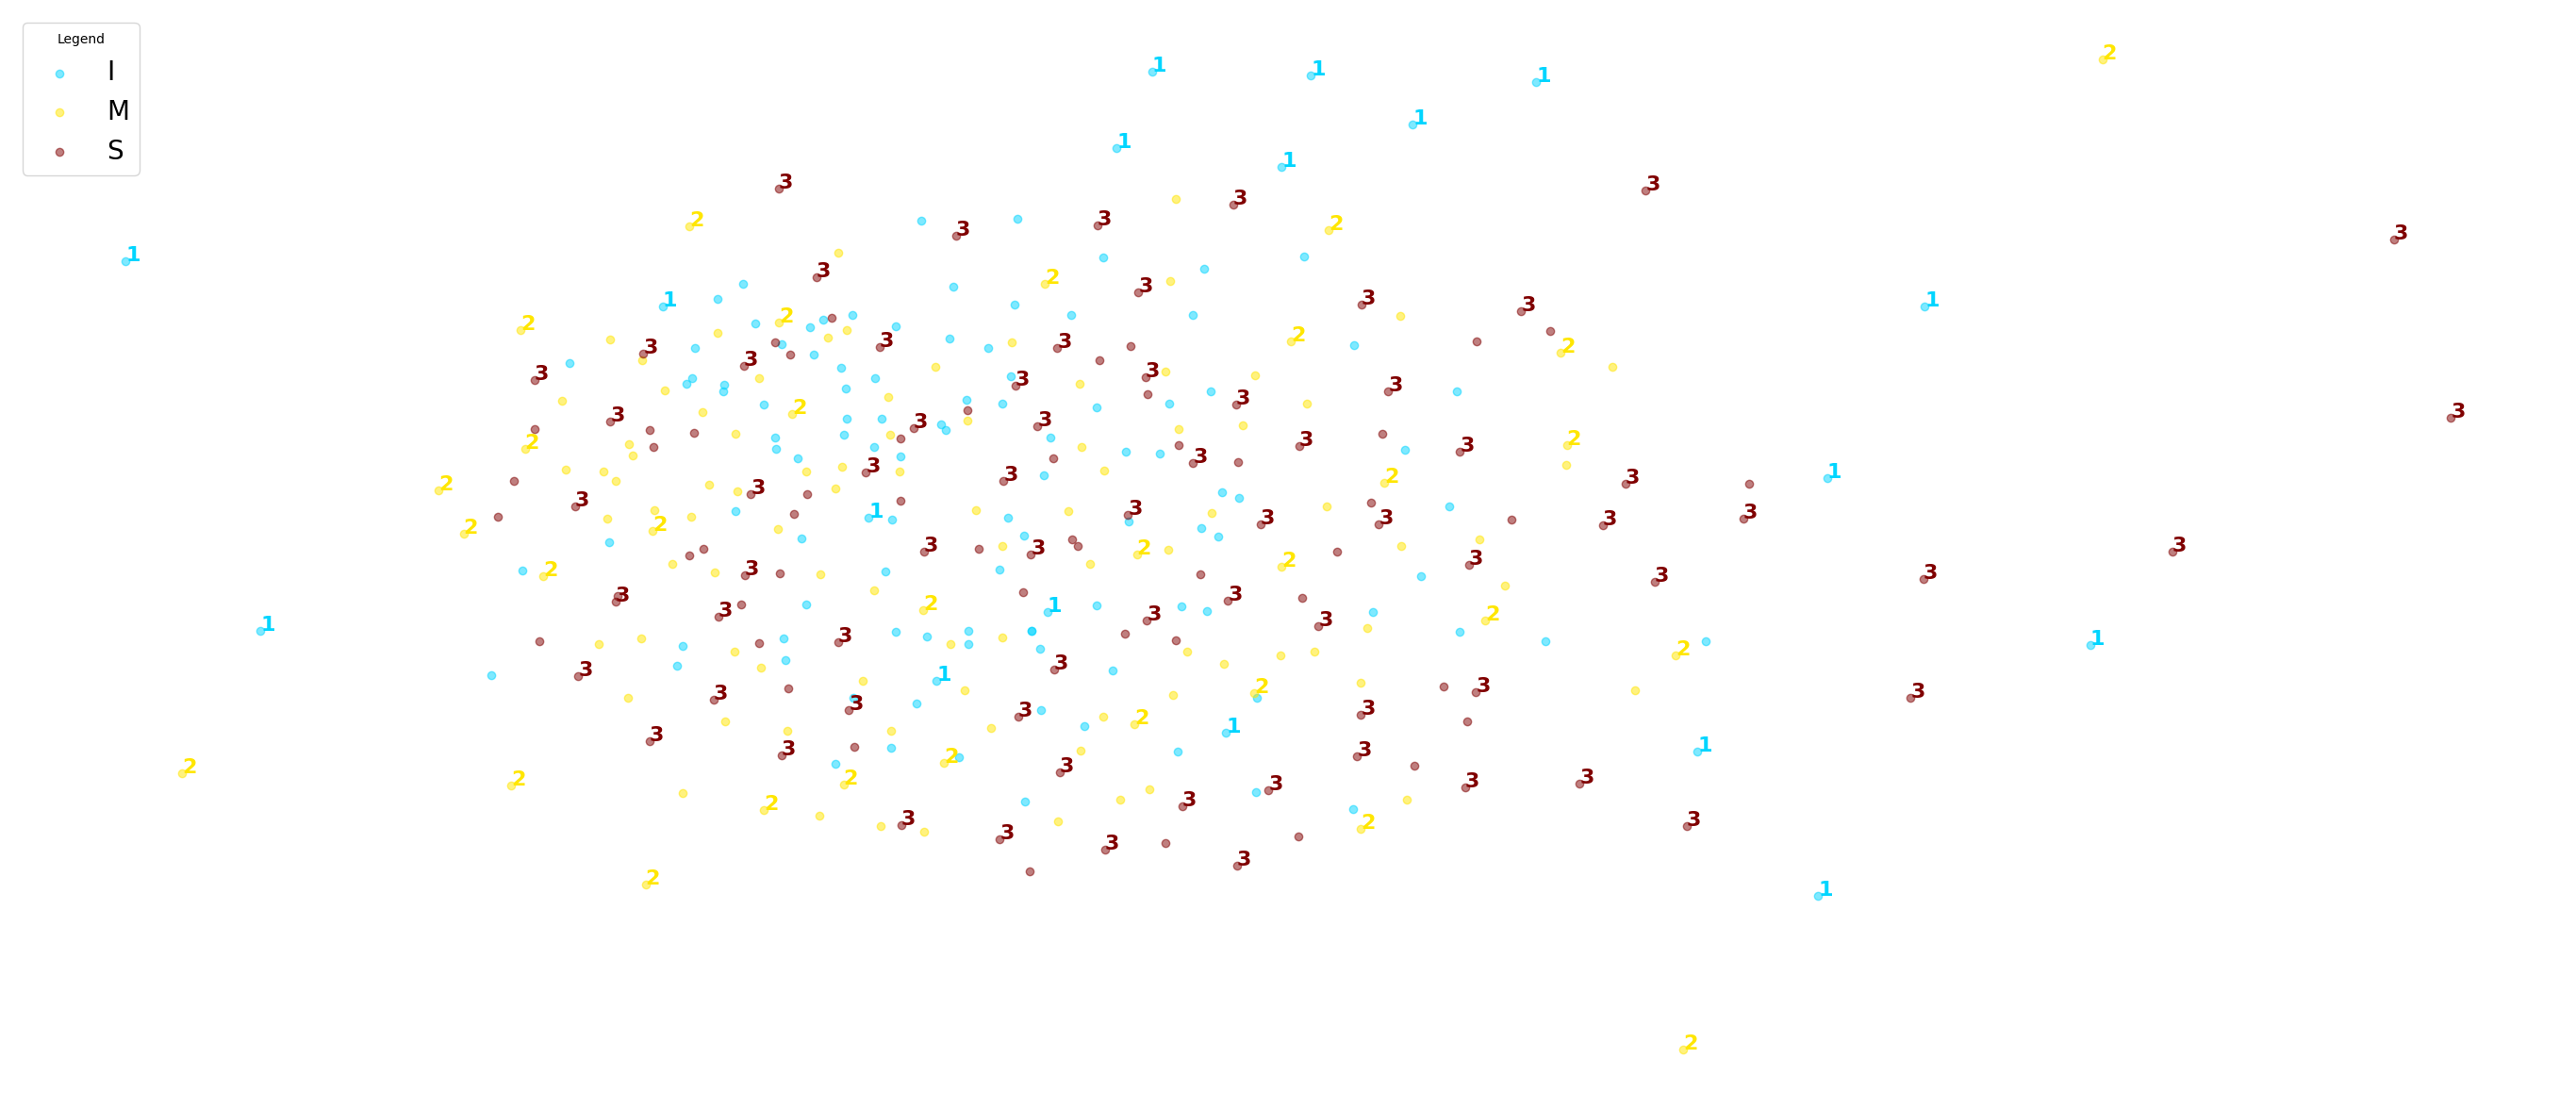

In [79]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(standardized_data_360)
plot_digits(X_reduced_mds, new_labels,figsize=(35, 15))

[1 2 3]


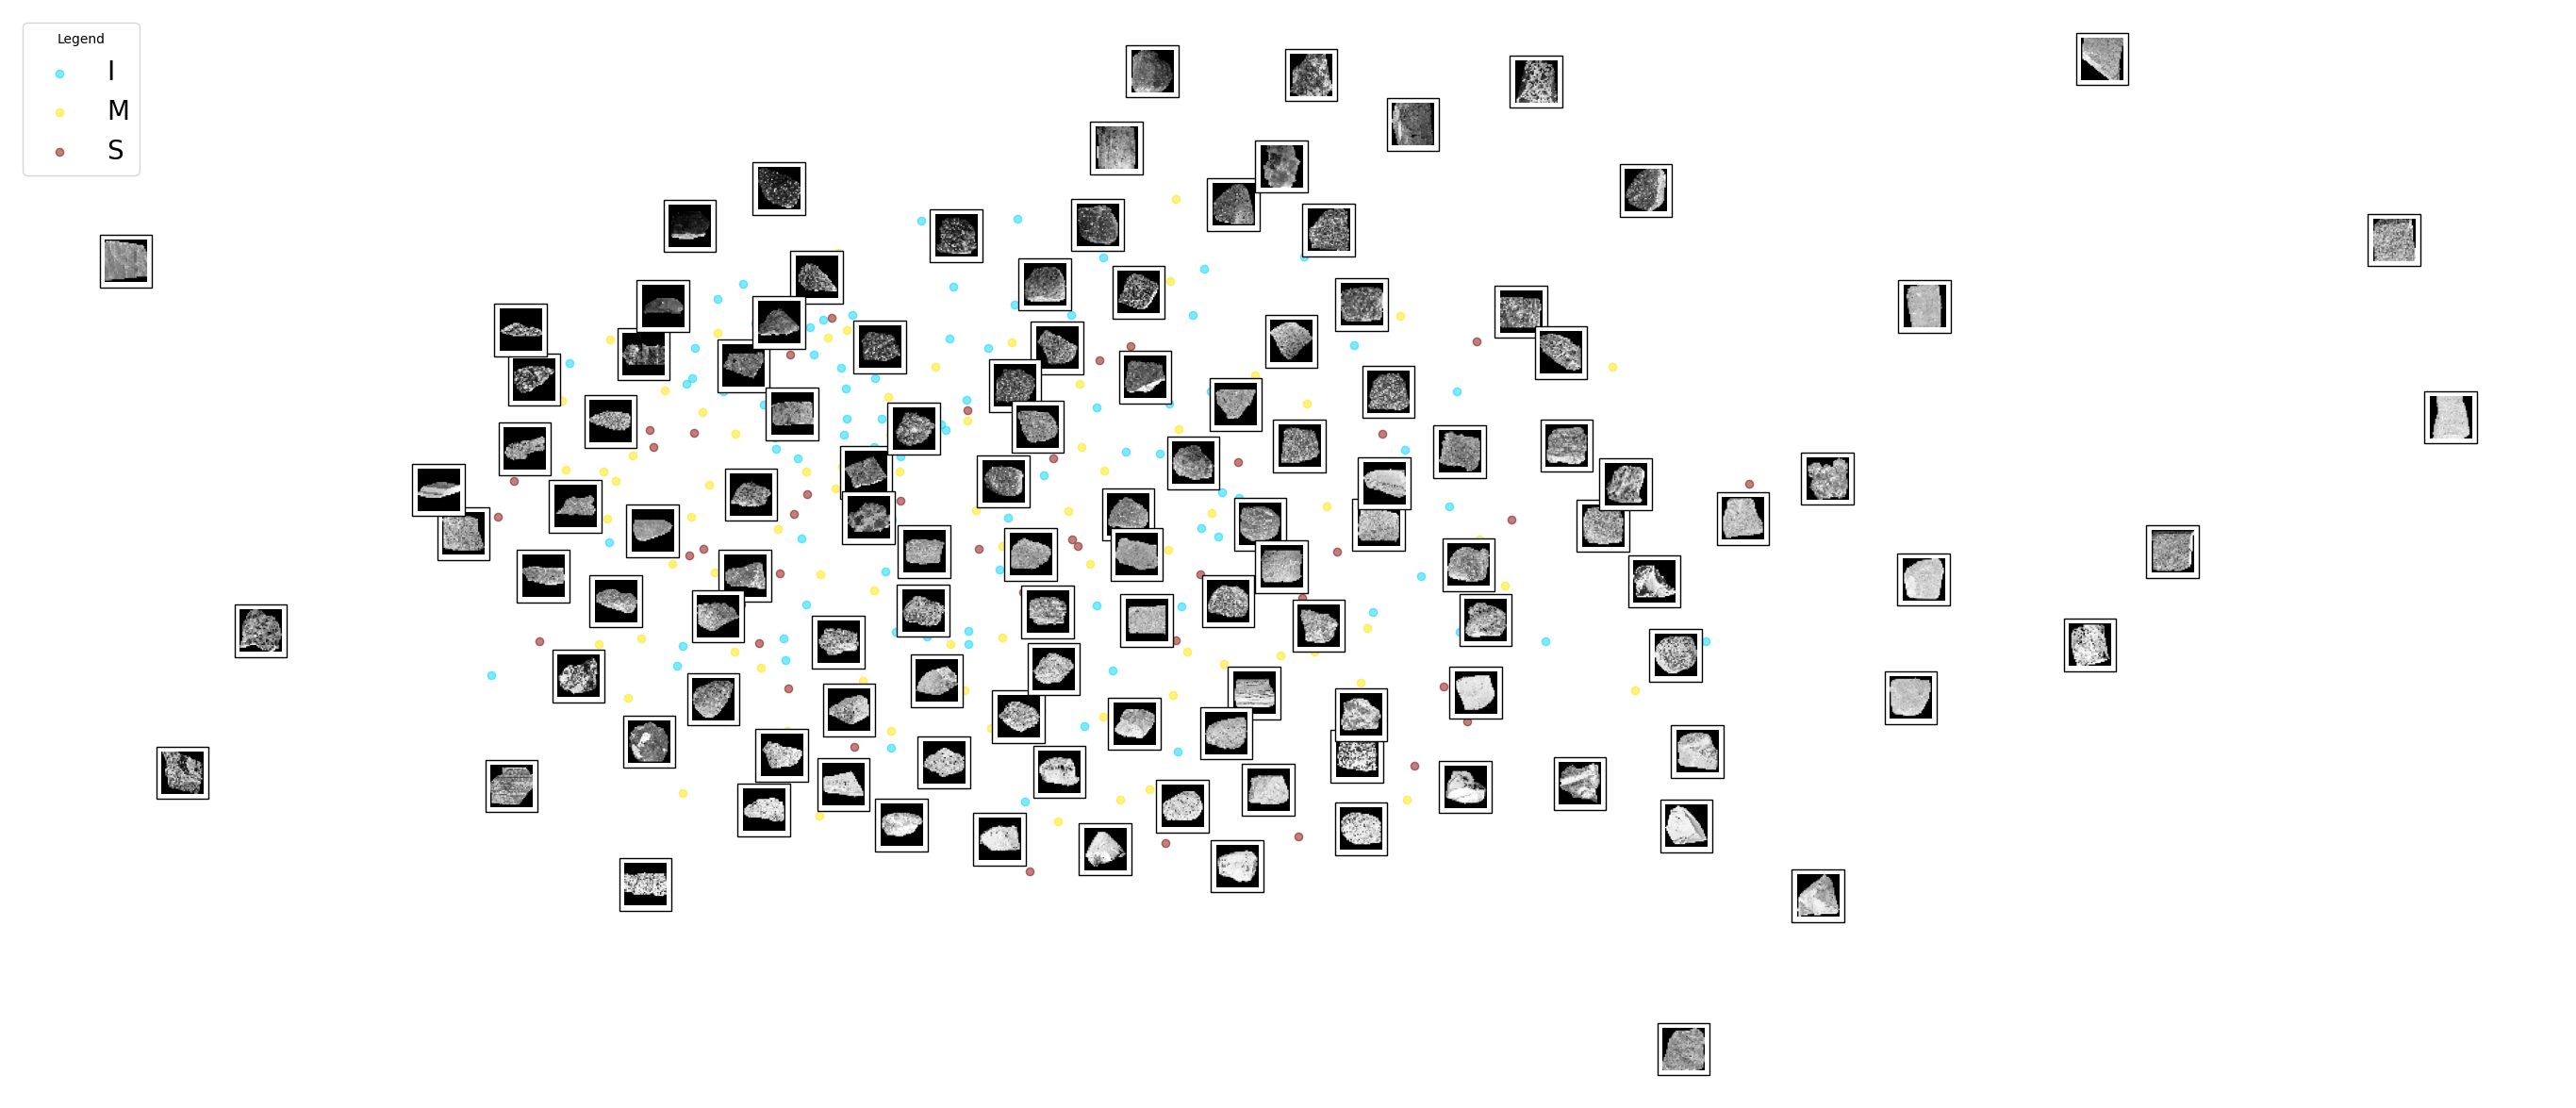

In [80]:
plot_digits(X_reduced_mds,new_labels,images=resized_images_2, figsize=(35, 15))

## 3 C.  Discussion on the visualizations (preferred or not)
All of the 4 representations are not able to decisively diffrentiate the classes, So PCA is somewhat better than the other ones.

## Question-4

## PCA

In [81]:
pca_subset = PCA(n_components=8, random_state=42)
X_pca = pca_subset.fit_transform(standardized_data_360)

In [82]:
file_path = '/content/drive/MyDrive/mds_360.txt'
list_of_lists = []
with open(file_path, 'r') as file:
    for line in file:
        line_list = line.strip().split()
        list_of_lists.append(line_list)
# human_features=np.array(list_of_lists)

In [84]:
human_features=np.array(list_of_lists)

### Disparity PCA

In [85]:
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(human_features, X_pca)
disparity

0.8722134324789544

In [88]:
correlation_coeff= np.corrcoef(mtx1.T, mtx2.T)
correlation_coeff.shape

(16, 16)

### Correlation  Matrix PCA 1

In [89]:
import pandas as pd
pd.DataFrame(correlation_coeff)

0         1         2         3         4         5         6   \
0   1.000000  0.044081  0.063477 -0.155535  0.000990  0.124124 -0.018356   
1   0.044081  1.000000  0.363519 -0.006691 -0.049845  0.067907  0.184426   
2   0.063477  0.363519  1.000000  0.009255 -0.096539  0.031344  0.148795   
3  -0.155535 -0.006691  0.009255  1.000000 -0.142254 -0.028801 -0.022183   
4   0.000990 -0.049845 -0.096539 -0.142254  1.000000 -0.132844  0.027251   
5   0.124124  0.067907  0.031344 -0.028801 -0.132844  1.000000 -0.023419   
6  -0.018356  0.184426  0.148795 -0.022183  0.027251 -0.023419  1.000000   
7   0.018403  0.171138  0.132954 -0.093100 -0.050094  0.012571  0.009323   
8   0.851628  0.091039  0.115828 -0.158522  0.117566  0.058453 -0.111748   
9   0.195819  0.137275 -0.072272 -0.177602  0.037779  0.098274  0.128947   
10  0.130649 -0.037899  0.244478  0.053797 -0.035664 -0.077374 -0.098414   
11 -0.305187 -0.158964  0.091821  0.297678 -0.078029 -0.099337 -0.091541   
12  0.233572  0.034895 -0.062817 -0.080522  0.159839 -0.040971 -0.055777   
13  0.093819  0.073331 -0.110098 -0.082816 -0.033099  0.267883  0.176827   
14 -0.126649  0.067943 -0.098884 -0.053889 -0.031818  0.124862  0.196007   
15  0.063147 -0.016360  0.006311 -0.013411  0.065902 -0.030832 -0.064652   

          7         8         9         10        11        12        13  \
0   0.018403  0.851628  0.195819  0.130649 -0.305187  0.233572  0.093819   
1   0.171138  0.091039  0.137275 -0.037899 -0.158964  0.034895  0.073331   
2   0.132954  0.115828 -0.072272  0.244478  0.091821 -0.062817 -0.110098   
3  -0.093100 -0.158522 -0.177602  0.053797  0.297678 -0.080522 -0.082816   
4  -0.050094  0.117566  0.037779 -0.035664 -0.078029  0.159839 -0.033099   
5   0.012571  0.058453  0.098274 -0.077374 -0.099337 -0.040971  0.267883   
6   0.009323 -0.111748  0.128947 -0.098414 -0.091541 -0.055777  0.176827   
7   1.000000  0.037036 -0.020639  0.004175 -0.015143  0.076791 -0.029023   
8   0.037036  1.000000  0.009887  0.144030 -0.186920  0.233343 -0.104102   
9  -0.020639  0.009887  1.000000  0.048180 -0.128964  0.223346  0.161953   
10  0.004175  0.144030  0.048180  1.000000  0.309322  0.046939 -0.391087   
11 -0.015143 -0.186920 -0.128964  0.309322  1.000000 -0.141753 -0.304725   
12  0.076791  0.233343  0.223346  0.046939 -0.141753  1.000000  0.040864   
13 -0.029023 -0.104102  0.161953 -0.391087 -0.304725  0.040864  1.000000   
14 -0.042975 -0.244971 -0.032495 -0.603153 -0.328822 -0.028488  0.451146   
15  0.057744  0.171662 -0.234393 -0.145307 -0.147966 -0.002029 -0.017684   

          14        15  
0  -0.126649  0.063147  
1   0.067943 -0.016360  
2  -0.098884  0.006311  
3  -0.053889 -0.013411  
4  -0.031818  0.065902  
5   0.124862 -0.030832  
6   0.196007 -0.064652  
7  -0.042975  0.057744  
8  -0.244971  0.171662  
9  -0.032495 -0.234393  
10 -0.603153 -0.145307  
11 -0.328822 -0.147966  
12 -0.028488 -0.002029  
13  0.451146 -0.017684  
14  1.000000  0.143875  
15  0.143875  1.000000

### The Correlation Function shows the correlation of one set of components with another, excluding the correlation of features within its own set.

In [86]:
def correl_mat(arr1,arr2):
  arr1,arr2=arr1.T,arr2.T
  res=[]
  for i in range(len(arr1)):
    row_coeff=[]
    for j in range(len(arr2)):
      coeff_val=np.corrcoef(arr1[i], arr2[j])[0, 1]
      row_coeff.append(round(coeff_val,2))
    res.append(row_coeff)
  return res

In [87]:
import pandas as pd
df_corr_PCA = pd.DataFrame(correl_mat(mtx1,mtx2))

### Correlation  Matrix PCA 2

In [88]:
df_corr_PCA

0     1     2     3     4     5     6     7
0  0.85  0.20  0.13 -0.31  0.23  0.09 -0.13  0.06
1  0.09  0.14 -0.04 -0.16  0.03  0.07  0.07 -0.02
2  0.12 -0.07  0.24  0.09 -0.06 -0.11 -0.10  0.01
3 -0.16 -0.18  0.05  0.30 -0.08 -0.08 -0.05 -0.01
4  0.12  0.04 -0.04 -0.08  0.16 -0.03 -0.03  0.07
5  0.06  0.10 -0.08 -0.10 -0.04  0.27  0.12 -0.03
6 -0.11  0.13 -0.10 -0.09 -0.06  0.18  0.20 -0.06
7  0.04 -0.02  0.00 -0.02  0.08 -0.03 -0.04  0.06

## LLE

In [93]:
lle = LocallyLinearEmbedding(n_components=8, random_state=42)
X_lle_reduced = lle.fit_transform(standardized_data_360)

### Disparity LLE

In [94]:
mtx1, mtx2, disparity = procrustes(human_features, X_lle_reduced)
disparity

0.9166057288286753

### Correlation  Matrix LLE 1

In [95]:
correlation_coeff= np.corrcoef(mtx1.T, mtx2.T)
pd.DataFrame(correlation_coeff)

0         1         2         3         4         5         6   \
0   1.000000  0.044081  0.063477 -0.155535  0.000990  0.124124 -0.018356   
1   0.044081  1.000000  0.363519 -0.006691 -0.049845  0.067907  0.184426   
2   0.063477  0.363519  1.000000  0.009255 -0.096539  0.031344  0.148795   
3  -0.155535 -0.006691  0.009255  1.000000 -0.142254 -0.028801 -0.022183   
4   0.000990 -0.049845 -0.096539 -0.142254  1.000000 -0.132844  0.027251   
5   0.124124  0.067907  0.031344 -0.028801 -0.132844  1.000000 -0.023419   
6  -0.018356  0.184426  0.148795 -0.022183  0.027251 -0.023419  1.000000   
7   0.018403  0.171138  0.132954 -0.093100 -0.050094  0.012571  0.009323   
8   0.775680  0.088802  0.067880 -0.079126  0.099260  0.077500 -0.051767   
9   0.082456  0.261300  0.103015 -0.165444  0.015271  0.014537  0.058265   
10  0.050498  0.082535  0.216634 -0.035748 -0.037355 -0.092164 -0.042281   
11 -0.072358 -0.162937 -0.043942  0.206901 -0.022718 -0.069067 -0.031435   
12  0.074957  0.012419 -0.037919 -0.018761  0.093060  0.004963 -0.062259   
13  0.073837  0.014916 -0.118031 -0.071957  0.006261  0.234065  0.191562   
14 -0.036755  0.044552 -0.040352 -0.024406 -0.058536  0.142757  0.304692   
15  0.012010  0.003772 -0.014905 -0.002363  0.058022 -0.020196 -0.035520   

          7             8             9             10            11  \
0   0.018403  7.756795e-01  8.245609e-02  5.049835e-02 -7.235844e-02   
1   0.171138  8.880195e-02  2.612997e-01  8.253450e-02 -1.629369e-01   
2   0.132954  6.788004e-02  1.030150e-01  2.166340e-01 -4.394202e-02   
3  -0.093100 -7.912638e-02 -1.654443e-01 -3.574763e-02  2.069012e-01   
4  -0.050094  9.926017e-02  1.527072e-02 -3.735547e-02 -2.271830e-02   
5   0.012571  7.750036e-02  1.453735e-02 -9.216420e-02 -6.906718e-02   
6   0.009323 -5.176748e-02  5.826529e-02 -4.228083e-02 -3.143475e-02   
7   1.000000  1.721279e-02  5.020423e-03 -1.589188e-02 -3.096696e-03   
8   0.017213  1.000000e+00 -1.508107e-16  5.070358e-17  6.240441e-17   
9   0.005020 -1.508107e-16  1.000000e+00 -4.472316e-16 -3.546001e-16   
10 -0.015892  5.070358e-17 -4.472316e-16  1.000000e+00  4.326056e-16   
11 -0.003097  6.240441e-17 -3.546001e-16  4.326056e-16  1.000000e+00   
12  0.062798  1.131080e-16  5.200368e-18 -7.176507e-16 -4.043286e-16   
13 -0.027578 -7.020496e-17  5.343378e-16 -4.264301e-16 -6.422454e-16   
14 -0.036146  3.779916e-16 -4.368309e-16  4.420312e-16 -2.496176e-16   
15  0.107976 -2.184154e-16  4.836342e-16 -5.200368e-17 -5.356379e-16   

              12            13            14            15  
0   7.495695e-02  7.383706e-02 -3.675487e-02  1.200971e-02  
1   1.241927e-02  1.491611e-02  4.455204e-02  3.772429e-03  
2  -3.791892e-02 -1.180315e-01 -4.035211e-02 -1.490463e-02  
3  -1.876052e-02 -7.195724e-02 -2.440619e-02 -2.362717e-03  
4   9.306002e-02  6.261303e-03 -5.853583e-02  5.802185e-02  
5   4.962848e-03  2.340655e-01  1.427569e-01 -2.019628e-02  
6  -6.225881e-02  1.915622e-01  3.046919e-01 -3.552045e-02  
7   6.279823e-02 -2.757789e-02 -3.614559e-02  1.079760e-01  
8   1.131080e-16 -7.020496e-17  3.779916e-16 -2.184154e-16  
9   5.200368e-18  5.343378e-16 -4.368309e-16  4.836342e-16  
10 -7.176507e-16 -4.264301e-16  4.420312e-16 -5.200368e-17  
11 -4.043286e-16 -6.422454e-16 -2.496176e-16 -5.356379e-16  
12  1.000000e+00 -3.081218e-16 -3.848272e-16 -1.560110e-16  
13 -3.081218e-16  1.000000e+00  8.944632e-16  4.264301e-16  
14 -3.848272e-16  8.944632e-16  1.000000e+00 -7.956562e-16  
15 -1.560110e-16  4.264301e-16 -7.956562e-16  1.000000e+00

### Correlation  Matrix LLE 2

In [96]:
df_corr_LLE = pd.DataFrame(correl_mat(mtx1,mtx2))
df_corr_LLE

0     1     2     3     4     5     6     7
0  0.78  0.08  0.05 -0.07  0.07  0.07 -0.04  0.01
1  0.09  0.26  0.08 -0.16  0.01  0.01  0.04  0.00
2  0.07  0.10  0.22 -0.04 -0.04 -0.12 -0.04 -0.01
3 -0.08 -0.17 -0.04  0.21 -0.02 -0.07 -0.02 -0.00
4  0.10  0.02 -0.04 -0.02  0.09  0.01 -0.06  0.06
5  0.08  0.01 -0.09 -0.07  0.00  0.23  0.14 -0.02
6 -0.05  0.06 -0.04 -0.03 -0.06  0.19  0.30 -0.04
7  0.02  0.01 -0.02 -0.00  0.06 -0.03 -0.04  0.11

## TNSE

In [89]:
tsne_subset = TSNE(n_components=8, random_state=42,method='exact')
data_tnse = tsne_subset.fit_transform(standardized_data_360)

### Disparity TNSE

In [91]:
mtx1, mtx2, disparity = procrustes(human_features, data_tnse)
disparity

0.9118792118362247

### Correlation Matrix TNSE 1

In [92]:
correlation_coeff= np.corrcoef(mtx1.T, mtx2.T)
pd.DataFrame(correlation_coeff)

0         1         2         3         4         5         6   \
0   1.000000  0.044081  0.063477 -0.155535  0.000990  0.124124 -0.018356   
1   0.044081  1.000000  0.363519 -0.006691 -0.049845  0.067907  0.184426   
2   0.063477  0.363519  1.000000  0.009255 -0.096539  0.031344  0.148795   
3  -0.155535 -0.006691  0.009255  1.000000 -0.142254 -0.028801 -0.022183   
4   0.000990 -0.049845 -0.096539 -0.142254  1.000000 -0.132844  0.027251   
5   0.124124  0.067907  0.031344 -0.028801 -0.132844  1.000000 -0.023419   
6  -0.018356  0.184426  0.148795 -0.022183  0.027251 -0.023419  1.000000   
7   0.018403  0.171138  0.132954 -0.093100 -0.050094  0.012571  0.009323   
8   0.785102  0.104080  0.103183 -0.136471  0.136059  0.040051 -0.077068   
9   0.109834  0.162815 -0.002584 -0.048931  0.023016  0.047129  0.043061   
10  0.124078 -0.002945  0.172397 -0.008902  0.015722 -0.132864 -0.158156   
11 -0.226281 -0.076882 -0.012274  0.199081 -0.106505 -0.041220 -0.019143   
12  0.195526  0.031343  0.018789 -0.092308  0.099187 -0.039084  0.015846   
13  0.044011  0.049075 -0.121413 -0.027318 -0.029886  0.226019  0.129884   
14 -0.077798  0.041192 -0.132769 -0.011654  0.011131  0.119320  0.202401   
15  0.062915  0.078658  0.032250 -0.009911  0.012713  0.021354 -0.018484   

          7         8         9         10        11        12        13  \
0   0.018403  0.785102  0.109834  0.124078 -0.226281  0.195526  0.044011   
1   0.171138  0.104080  0.162815 -0.002945 -0.076882  0.031343  0.049075   
2   0.132954  0.103183 -0.002584  0.172397 -0.012274  0.018789 -0.121413   
3  -0.093100 -0.136471 -0.048931 -0.008902  0.199081 -0.092308 -0.027318   
4  -0.050094  0.136059  0.023016  0.015722 -0.106505  0.099187 -0.029886   
5   0.012571  0.040051  0.047129 -0.132864 -0.041220 -0.039084  0.226019   
6   0.009323 -0.077068  0.043061 -0.158156 -0.019143  0.015846  0.129884   
7   1.000000  0.042057  0.055487  0.025924 -0.010986  0.012212  0.015686   
8   0.042057  1.000000  0.110988  0.227158 -0.177718  0.144536  0.006837   
9   0.055487  0.110988  1.000000 -0.238644  0.109807 -0.287555  0.577810   
10  0.025924  0.227158 -0.238644  1.000000  0.053988  0.264125 -0.427232   
11 -0.010986 -0.177718  0.109807  0.053988  1.000000 -0.196905  0.146086   
12  0.012212  0.144536 -0.287555  0.264125 -0.196905  1.000000 -0.246378   
13  0.015686  0.006837  0.577810 -0.427232  0.146086 -0.246378  1.000000   
14 -0.012473 -0.236399 -0.052155 -0.197075 -0.116165  0.211635  0.073992   
15  0.093088  0.114332  0.071121  0.148948  0.033754  0.067981  0.074780   

          14        15  
0  -0.077798  0.062915  
1   0.041192  0.078658  
2  -0.132769  0.032250  
3  -0.011654 -0.009911  
4   0.011131  0.012713  
5   0.119320  0.021354  
6   0.202401 -0.018484  
7  -0.012473  0.093088  
8  -0.236399  0.114332  
9  -0.052155  0.071121  
10 -0.197075  0.148948  
11 -0.116165  0.033754  
12  0.211635  0.067981  
13  0.073992  0.074780  
14  1.000000  0.171390  
15  0.171390  1.000000

### Correlation Matrix TNSE 2

In [93]:
df_corr_TNSE = pd.DataFrame(correl_mat(mtx1,mtx2))
df_corr_TNSE

0     1     2     3     4     5     6     7
0  0.79  0.11  0.12 -0.23  0.20  0.04 -0.08  0.06
1  0.10  0.16 -0.00 -0.08  0.03  0.05  0.04  0.08
2  0.10 -0.00  0.17 -0.01  0.02 -0.12 -0.13  0.03
3 -0.14 -0.05 -0.01  0.20 -0.09 -0.03 -0.01 -0.01
4  0.14  0.02  0.02 -0.11  0.10 -0.03  0.01  0.01
5  0.04  0.05 -0.13 -0.04 -0.04  0.23  0.12  0.02
6 -0.08  0.04 -0.16 -0.02  0.02  0.13  0.20 -0.02
7  0.04  0.06  0.03 -0.01  0.01  0.02 -0.01  0.09

## MDS

In [96]:
mds = MDS(n_components=8, random_state=42)
X_reduced_mds = mds.fit_transform(standardized_data_360)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## Disparity MDS

In [97]:
mtx1, mtx2, disparity = procrustes(human_features, X_reduced_mds)
disparity

0.8868621312825201

### Correlation Matrix MDS 1

In [100]:
correlation_coeff= np.corrcoef(mtx1.T, mtx2.T)
pd.DataFrame(correlation_coeff)


0         1         2         3         4         5         6   \
0   1.000000  0.044081  0.063477 -0.155535  0.000990  0.124124 -0.018356   
1   0.044081  1.000000  0.363519 -0.006691 -0.049845  0.067907  0.184426   
2   0.063477  0.363519  1.000000  0.009255 -0.096539  0.031344  0.148795   
3  -0.155535 -0.006691  0.009255  1.000000 -0.142254 -0.028801 -0.022183   
4   0.000990 -0.049845 -0.096539 -0.142254  1.000000 -0.132844  0.027251   
5   0.124124  0.067907  0.031344 -0.028801 -0.132844  1.000000 -0.023419   
6  -0.018356  0.184426  0.148795 -0.022183  0.027251 -0.023419  1.000000   
7   0.018403  0.171138  0.132954 -0.093100 -0.050094  0.012571  0.009323   
8   0.845304  0.094960  0.113405 -0.168581  0.115896  0.067481 -0.102669   
9   0.138892  0.224331  0.047004 -0.101509  0.013081  0.046363  0.101591   
10  0.101989  0.028901  0.273262  0.077684 -0.035498 -0.061277 -0.067237   
11 -0.234213 -0.096421  0.120009  0.308480 -0.061040 -0.055491 -0.092346   
12  0.136138  0.010505 -0.046366 -0.051608  0.174151 -0.014310 -0.016933   
13  0.081113  0.038102 -0.081901 -0.048010 -0.014644  0.233949  0.145243   
14 -0.104749  0.070865 -0.076278 -0.067815 -0.014708  0.123280  0.202955   
15  0.046084  0.004039  0.015897  0.022434  0.041746 -0.023970 -0.021249   

          7         8         9         10        11        12        13  \
0   0.018403  0.845304  0.138892  0.101989 -0.234213  0.136138  0.081113   
1   0.171138  0.094960  0.224331  0.028901 -0.096421  0.010505  0.038102   
2   0.132954  0.113405  0.047004  0.273262  0.120009 -0.046366 -0.081901   
3  -0.093100 -0.168581 -0.101509  0.077684  0.308480 -0.051608 -0.048010   
4  -0.050094  0.115896  0.013081 -0.035498 -0.061040  0.174151 -0.014644   
5   0.012571  0.067481  0.046363 -0.061277 -0.055491 -0.014310  0.233949   
6   0.009323 -0.102669  0.101591 -0.067237 -0.092346 -0.016933  0.145243   
7   1.000000  0.043739  0.005607  0.013569  0.029582  0.046542 -0.027346   
8   0.043739  1.000000  0.023499  0.111215 -0.048915  0.132466 -0.067961   
9   0.005607  0.023499  1.000000 -0.144239 -0.130445  0.004183  0.122343   
10  0.013569  0.111215 -0.144239  1.000000  0.102034 -0.082467 -0.303716   
11  0.029582 -0.048915 -0.130445  0.102034  1.000000 -0.061157 -0.093096   
12  0.046542  0.132466  0.004183 -0.082467 -0.061157  1.000000  0.049504   
13 -0.027346 -0.067961  0.122343 -0.303716 -0.093096  0.049504  1.000000   
14 -0.020576 -0.189537  0.064916 -0.110557 -0.050363 -0.069620  0.119445   
15  0.023540  0.039550  0.066083 -0.104611 -0.036021  0.052892  0.020587   

          14        15  
0  -0.104749  0.046084  
1   0.070865  0.004039  
2  -0.076278  0.015897  
3  -0.067815  0.022434  
4  -0.014708  0.041746  
5   0.123280 -0.023970  
6   0.202955 -0.021249  
7  -0.020576  0.023540  
8  -0.189537  0.039550  
9   0.064916  0.066083  
10 -0.110557 -0.104611  
11 -0.050363 -0.036021  
12 -0.069620  0.052892  
13  0.119445  0.020587  
14  1.000000 -0.001236  
15 -0.001236  1.000000

### Correlation Matrix MDS 2

In [101]:
df_corr_MDS = pd.DataFrame(correl_mat(mtx1,mtx2))
df_corr_MDS

0     1     2     3     4     5     6     7
0  0.85  0.14  0.10 -0.23  0.14  0.08 -0.10  0.05
1  0.09  0.22  0.03 -0.10  0.01  0.04  0.07  0.00
2  0.11  0.05  0.27  0.12 -0.05 -0.08 -0.08  0.02
3 -0.17 -0.10  0.08  0.31 -0.05 -0.05 -0.07  0.02
4  0.12  0.01 -0.04 -0.06  0.17 -0.01 -0.01  0.04
5  0.07  0.05 -0.06 -0.06 -0.01  0.23  0.12 -0.02
6 -0.10  0.10 -0.07 -0.09 -0.02  0.15  0.20 -0.02
7  0.04  0.01  0.01  0.03  0.05 -0.03 -0.02  0.02

## K-Means


## 5. A. K-means is implementation and using Intertia to check number of clusters

In [102]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [103]:
pca_subset = PCA(n_components=2, random_state=42)
X_pca = pca_subset.fit_transform(standardized_data_360)

In [104]:
dictn_kmeans={'no_of_clusters':[],'Silhouette_avg':[],'Inertia':[]}
for i in range(3,100):
  kmeans = KMeans(n_clusters=i,random_state=42,n_init=10)
  dictn_kmeans['no_of_clusters'].append(i)
  kmeans.fit(X_pca)
  cluster_labels = kmeans.labels_
  dictn_kmeans['Inertia'].append(kmeans.inertia_)
  silhouette_avg = silhouette_score(X_pca, cluster_labels)
  dictn_kmeans['Silhouette_avg'].append(silhouette_avg)



In [105]:
df_kmeans=pd.DataFrame(dictn_kmeans)

Text(0.5, 1.0, 'Inertia')

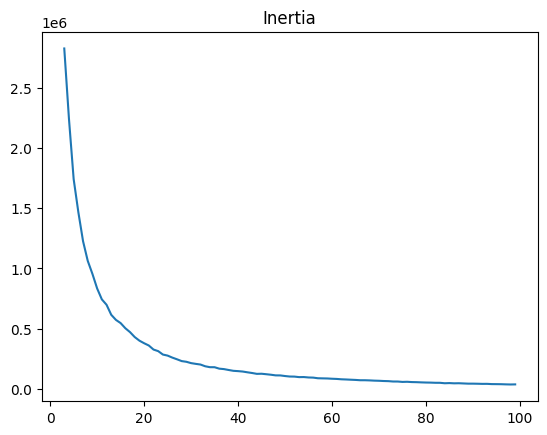

In [107]:
plt.plot(df_kmeans['no_of_clusters'],df_kmeans['Inertia'])
plt.title('Inertia')

Text(0.5, 1.0, 'Silhouette_avg')

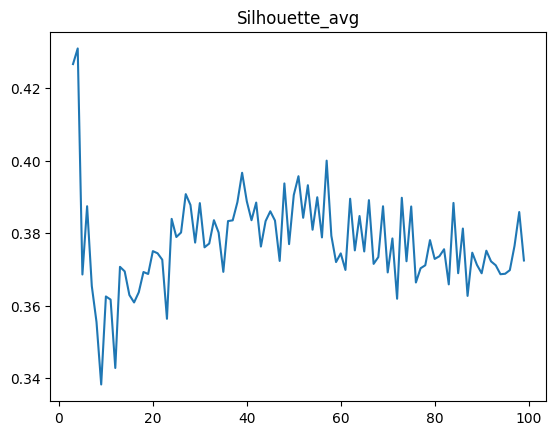

In [108]:
plt.plot(df_kmeans['no_of_clusters'],df_kmeans['Silhouette_avg'])
plt.title('Silhouette_avg')

In [112]:
import seaborn as sns

def plot_data(X,labels):
    # plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, data=X)



def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, lables_arr=None,resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,lables_arr)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)





## 5 B. Plots with boundaries can be inferred with centroids of each cluster

#### A. K means with actual number of classes

In [110]:
kmeans_rnd_inits = KMeans(n_clusters=3,random_state=42,n_init=10)
kmeans_rnd_inits.fit(X_pca)

KMeans(n_clusters=3, n_init=10, random_state=42)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


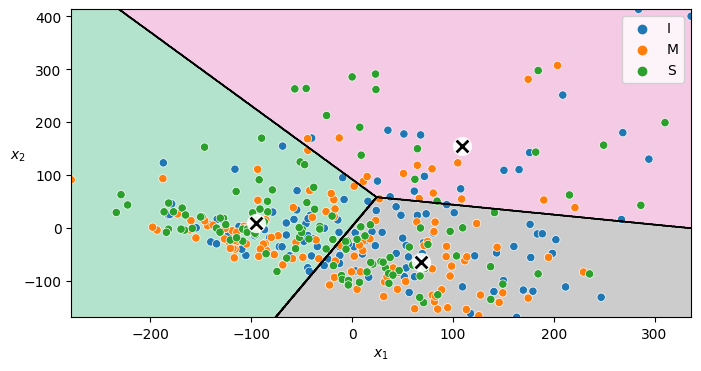

In [113]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_inits, X_pca,labels_360)

#### B. K means with classes we got from checking Inertia

In [114]:
kmeans_rnd_20_inits = KMeans(n_clusters=20,random_state=42,n_init=10)
kmeans_rnd_20_inits.fit(X_pca)

KMeans(n_clusters=20, n_init=10, random_state=42)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


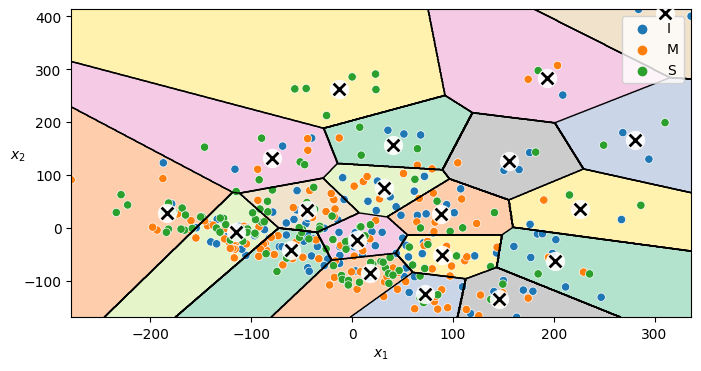

In [115]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_20_inits, X_pca,labels_360)

## 6 A. EM Implementation, Evaluation for the number of clusters using AIC

In [141]:
from sklearn.mixture import GaussianMixture

In [167]:
pca_subset = PCA(n_components=2, random_state=42)
X_pca = pca_subset.fit_transform(standardized_data_360)

In [168]:
dictn_gm={'no_of_clusters':[],'BIC':[]}
for i in range(2,50):
  gm = GaussianMixture(n_components=i, n_init=10)
  gm.fit(X_pca)
  dictn_gm['no_of_clusters'].append(i)
  bic = gm.bic(X_pca)
  dictn_gm['BIC'].append(bic)

In [169]:
df_gm=pd.DataFrame(dictn_gm)

Text(0.5, 1.0, 'BIC')

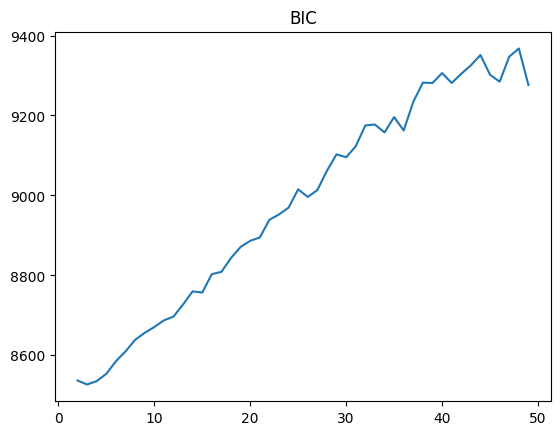

In [170]:
plt.plot(df_gm['no_of_clusters'],df_gm['BIC'])
plt.title('BIC')

In [171]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def plot_data(X, labels):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, data=X)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gmm_decision_boundaries(gmm, X, labels_arr=None, resolution=1000,
                                  show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))

    Z = np.argmax(gmm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X, labels_arr)

    if show_centroids:
        plot_centroids(gmm.means_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [172]:
best_gmm_model_full = GaussianMixture(n_components=3,n_init=5).fit(X_pca)

## 6 B. Plots with boundaries

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


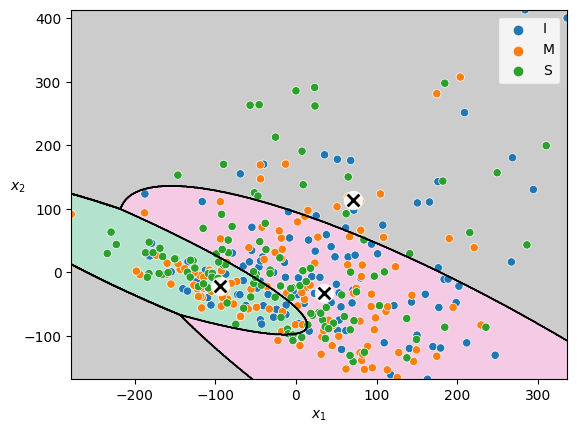

In [173]:
plot_gmm_decision_boundaries(best_gmm_model_full, X_pca,labels_360)

In [174]:
gmm_samples = best_gmm_model_full.sample(20)
X_sample,y_sample = gmm_samples

In [175]:
X_sample_recoverd = pca_subset.inverse_transform(X_sample)

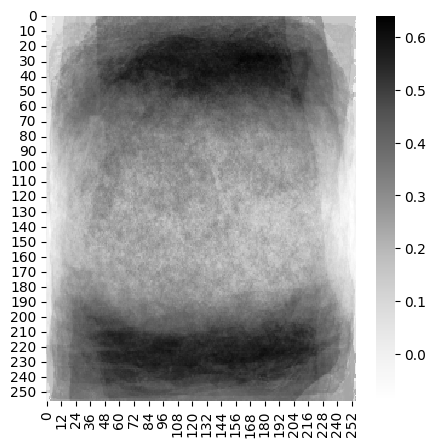

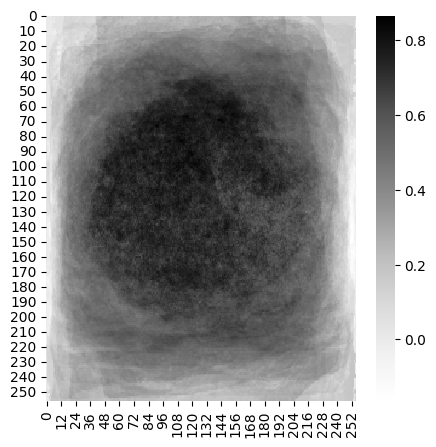

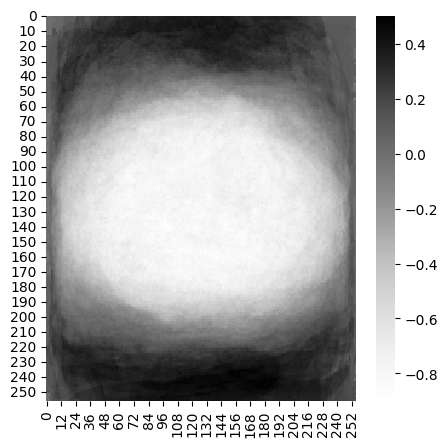

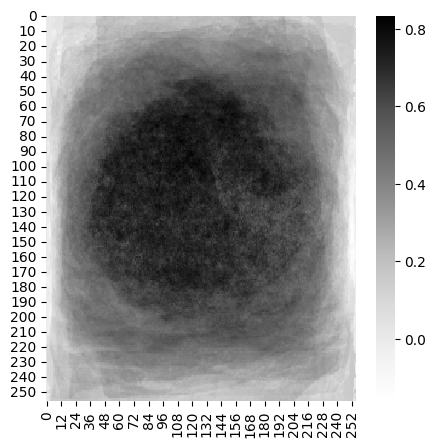

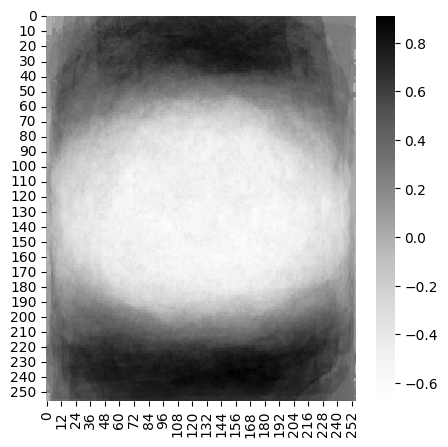

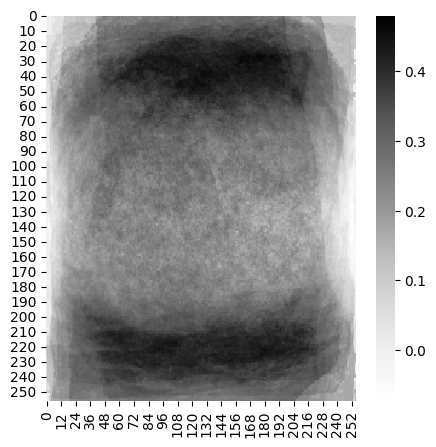

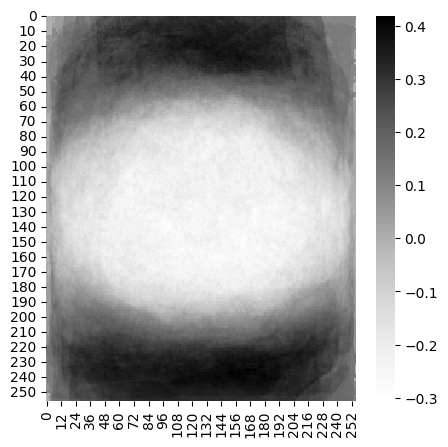

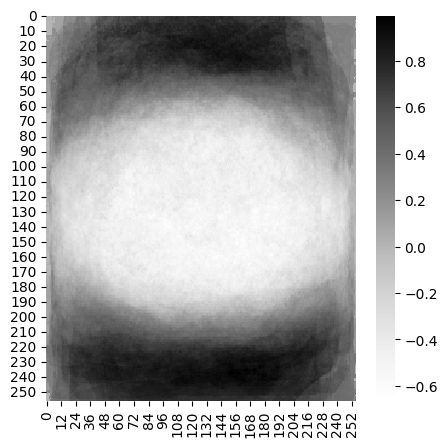

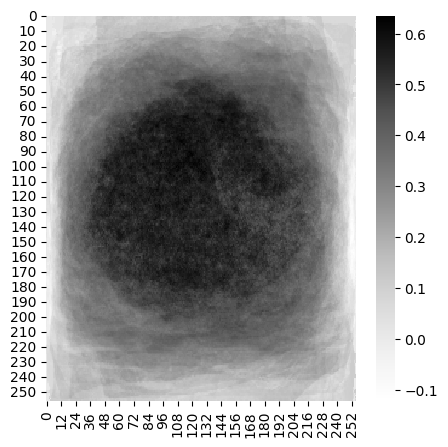

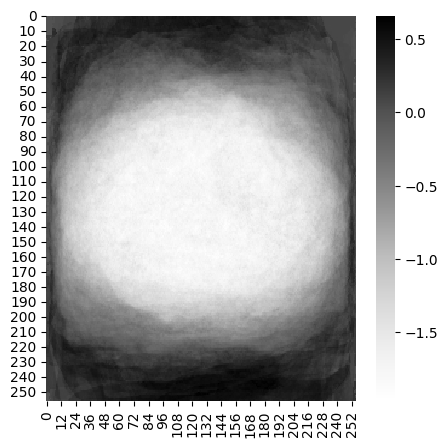

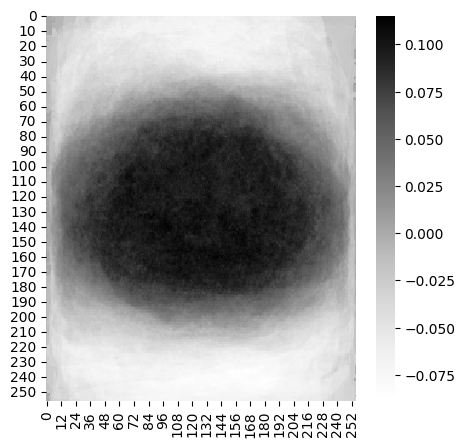

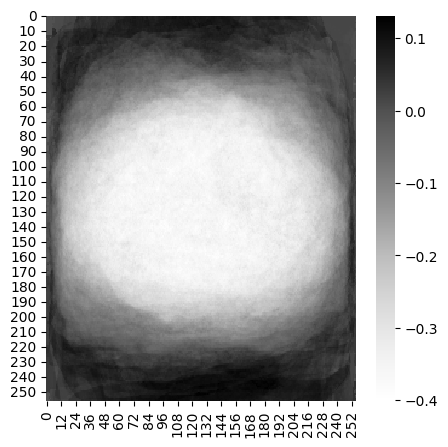

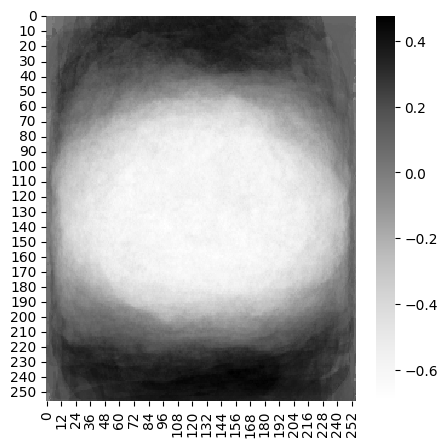

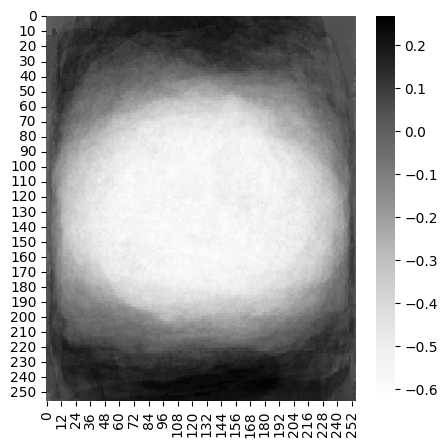

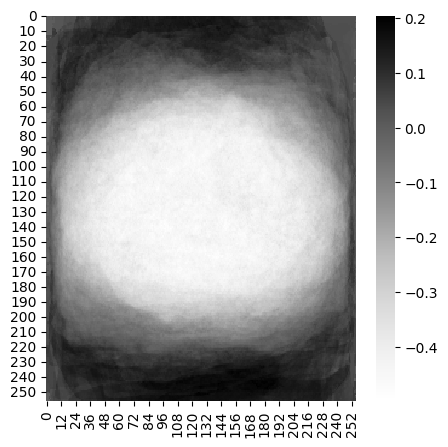

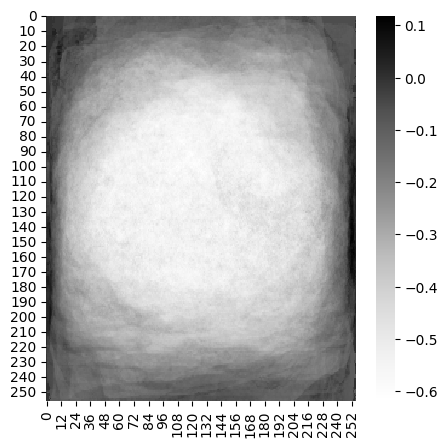

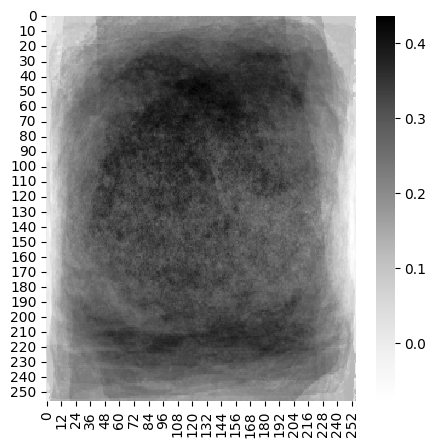

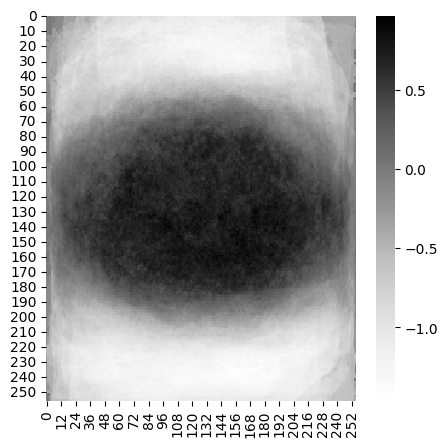

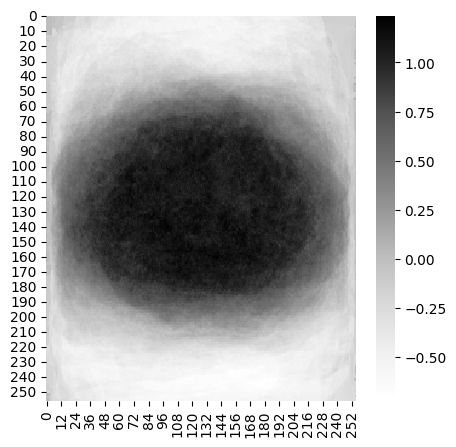

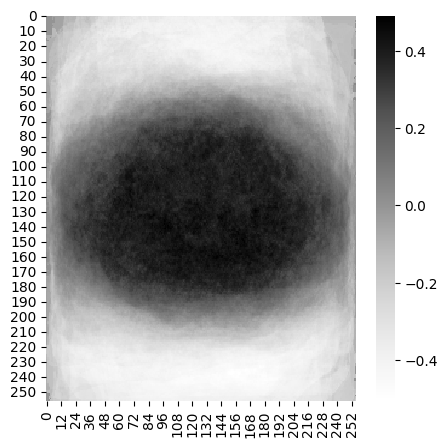

In [176]:
for idx in range(20):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(X_sample_recoverd[idx].reshape(256,256),ax=axs,cmap='Greys')


## 7. Neural Network

In [199]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dropout
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [200]:
def getImage(path):
  folder_path = path
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
  image_files=sorted(image_files)
  #storing Labels
  labels=[i[0] for i in image_files]

  resized_images = []

  for image_file in image_files:
      image_path = os.path.join(folder_path, image_file)
      original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      target_size = (300, 300)
      resized_image = cv2.resize(original_image, target_size)
      resized_images.append(resized_image)
  flattened_image = [img.flatten() for img in resized_images]
  return resized_images,flattened_image,labels

In [201]:
resized_images_360,flattened_image_360,labels_360=getImage('/tmp/360')
resized_images_120,flattened_image_120,labels_120=getImage('/tmp/120')

In [202]:


image_data = np.array(flattened_image_360)
labels = np.array(labels_360)


label_encoder = LabelEncoder()
labels_numerical = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
labels_onehot = onehot_encoder.fit_transform(labels_numerical.reshape(-1, 1))


model = keras.Sequential()
model.add(layers.Input(shape=(image_data.shape[1],)))  # Input layer
model.add(Dropout(rate=0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(rate=0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(rate=0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(24, activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(rate=0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation='relu',kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [203]:
valtest= np.array(flattened_image_120)

In [204]:
label_encoder_2 = LabelEncoder()
labels_numerical_2 = label_encoder.fit_transform(np.array(labels_120))
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
labels_onehot_val = onehot_encoder.fit_transform(labels_numerical_2.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [205]:
image_data.shape, valtest.shape

((360, 90000), (120, 90000))

In [206]:
labels_onehot_val.shape,labels_onehot.shape

((120, 3), (360, 3))

In [207]:
start_time = time.time()

# Train the model
history = model.fit(image_data, labels_onehot, validation_data=(valtest, labels_onehot_val), epochs=50, batch_size=32)

end_time = time.time()

Epoch 1/30
12/12 [==============================] - 5s 54ms/step - loss: 1.4966 - accuracy: 0.3056 - val_loss: 49.8316 - val_accuracy: 0.3333
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 1.2554 - accuracy: 0.3611 - val_loss: 17.4176 - val_accuracy: 0.3250
Epoch 3/30
12/12 [==============================] - 0s 22ms/step - loss: 1.1503 - accuracy: 0.4306 - val_loss: 7.8071 - val_accuracy: 0.3000
Epoch 4/30
12/12 [==============================] - 0s 19ms/step - loss: 1.1317 - accuracy: 0.4056 - val_loss: 4.2136 - val_accuracy: 0.3417
Epoch 5/30
12/12 [==============================] - 0s 19ms/step - loss: 1.1142 - accuracy: 0.4111 - val_loss: 3.8120 - val_accuracy: 0.3333
Epoch 6/30
12/12 [==============================] - 0s 15ms/step - loss: 1.0640 - accuracy: 0.4389 - val_loss: 3.1342 - val_accuracy: 0.3417
Epoch 7/30
12/12 [==============================] - 0s 16ms/step - loss: 1.0568 - accuracy: 0.4556 - val_loss: 2.4231 - val_accuracy: 0.3417
Epoch 8/30


 ## 7 B. Sequential Model Training, Validation incorporated, Plots
 #### Training and Validation loss is decreasing with epochs and accuracy is increasing. The Model is performing good on the Train set but not very much on the Validation set. Various Iterations of batch normalization and gradient clipping were emplyed but no satisfactory results were observed

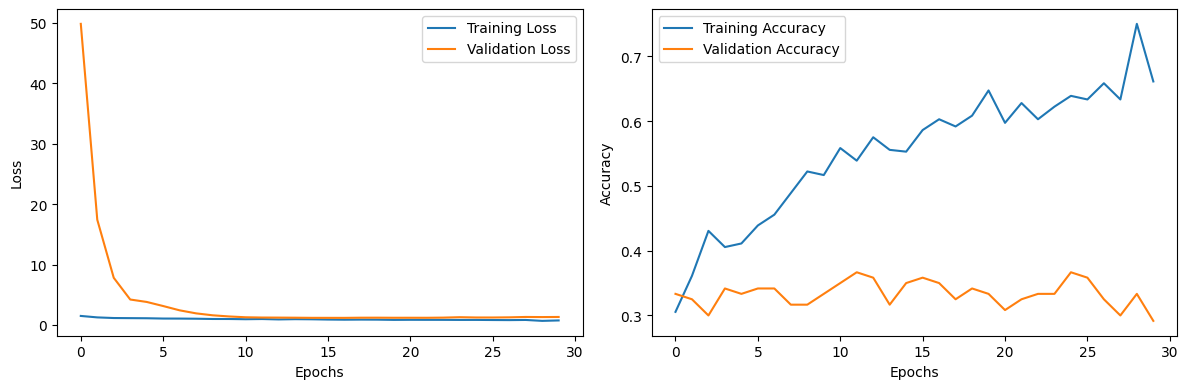

In [210]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model.save('rock_classification_model.h5')

## 7 A. Training Time

In [211]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 10.650020360946655 seconds


In [212]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 90000)             0         
                                                                 
 batch_normalization_5 (Bat  (None, 90000)             360000    
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 128)               11520128  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 64)               

## 7. C Total Number of parameters and Number of Bias Parameters
### Total params: 11891067
### Trainable params: 11710619
### Non-trainable params: 180448

## 7. D Disparity and Correlation tables for training data and for Validation Data

In [213]:
activation_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)

### Train

In [224]:
activations_train = activation_model.predict(image_data)
activations_val = activation_model.predict(valtest)

4/4 [==============================] - 0s 10ms/step


In [225]:
mtx1, mtx2, disparity = procrustes(human_features, activations_train)
disparity

0.8684985470057116

In [226]:
df_corr_nn_train = pd.DataFrame(correl_mat(mtx1,mtx2))
df_corr_nn_train

0     1     2     3     4     5     6     7
0  0.70 -0.07 -0.00 -0.07  0.06  0.09 -0.08  0.02
1 -0.03  0.29  0.05 -0.17 -0.04 -0.01  0.11  0.09
2 -0.00  0.06  0.20  0.03 -0.10  0.00 -0.00  0.03
3 -0.04 -0.19  0.02  0.24 -0.05 -0.02 -0.01  0.02
4  0.06 -0.06 -0.13 -0.08  0.36 -0.24 -0.19 -0.01
5  0.06 -0.02  0.00 -0.03 -0.18  0.29  0.09 -0.09
6 -0.11  0.28 -0.00 -0.03 -0.28  0.18  0.38  0.17
7  0.01  0.09  0.03  0.02 -0.01 -0.07  0.07  0.13

In [219]:
file_path = '/content/drive/MyDrive/mds_120.txt'
def read_text_file(path):
  list_of_lists = []
  with open(file_path, 'r') as file:
      for line in file:
          line_list = line.strip().split()
          list_of_lists.append(line_list)
  return np.array(list_of_lists)


### Validation

In [227]:
human_features_120=read_text_file(file_path)
human_features_120.shape

(120, 8)

In [228]:
mtx1, mtx2, disparity = procrustes(human_features_120, activations_val)
disparity

0.8705678282150932

In [229]:
df_corr_nn_val = pd.DataFrame(correl_mat(mtx1,mtx2))
df_corr_nn_val

0     1     2     3     4     5     6     7
0  0.69  0.15 -0.04 -0.24  0.18 -0.17  0.23  0.13
1  0.08  0.22  0.07 -0.04 -0.05 -0.00 -0.04 -0.04
2 -0.02  0.08  0.33  0.05 -0.12  0.07 -0.17  0.04
3 -0.10 -0.03  0.03  0.29  0.02 -0.09 -0.05 -0.04
4  0.07 -0.03 -0.08  0.02  0.18 -0.11  0.07  0.01
5 -0.09 -0.00  0.06 -0.12 -0.15  0.25 -0.08  0.09
6  0.11 -0.03 -0.13 -0.05  0.09 -0.07  0.37  0.10
7  0.07 -0.04  0.04 -0.06  0.02  0.09  0.11  0.29